# Time Series Analysis & Recurrent Neural Networks
## Final Project
### Lars Kühmichel, Nicolas Wolf

The final project is about analyzing the dynamics of a time series of weather data from across Europe. The goal is to
- reconstruct the dynamics behind the data, especially the annual and daily rhythms
- predict the future of the time series
- and compare two model architectures with respect to the results.

# Table of Contents

1. [Setup](#setup)
2. [Project Tasks](#project-tasks)
   1. [Train-Test-Split](#train-test-split)
   2. [Linear Gaussian Latent-Space Model](#linear-model)
   3. [Long Short-Term Memory RNN](#lstm)
   4. [Predictions for the Test Set](#test-set)
   5. [Power Spectrum Correlation](#psc)
3. [Appendix](#appendix)

# Setup <a name="setup"></a>

Please check [the public GitHub repository](https://github.com/LarsKue/TSA-RNN-final-project) for the exact project structure. We use external `.py` files for parallelization purposes, and put the provided code under a subdirectory `provided/`. You can also find optimal parameter weights for the VAR there.


In [1]:
# data manipulation
import pandas as pd
import numpy as np
import pathlib as pl
from scipy.signal import detrend

# plotting and display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# neural networks
import torch
import torch.nn as nn
import pytorch_lightning as lightning
import pytorch_lightning.loggers as loggers
from torch.utils.data import DataLoader, Dataset

# diverse
import multiprocessing as mp
import itertools
import ray.tune as tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

# provided code
try:
    import provided.PSC as psc
except ModuleNotFoundError:
    raise FileNotFoundError(f"Please follow the project structure as provided on the GitHub Repo, putting provided code under a separate subdirectory.")

In [2]:
# set default figure dpi and legend fontsize
# this just makes for nicer plotting by default
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

We first run a modified version of the provided code to download the dataset and save it locally.

In [3]:
def running_mean(x, N):
    w = np.ones(N) / N
    if x.ndim > 1:
        res = []
        for i in range(x.shape[1]):
            res.append(np.convolve(w, x[:, i], 'valid'))
        return np.array(res).T
    else:
        return np.convolve(w, x, 'valid')

In [4]:
data_root = pl.Path("data")
data_root.mkdir(exist_ok=True, parents=True)

data_path = data_root / "weather_data.csv"

if not data_path.is_file():
    data_url = r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv"
    data = pd.read_csv(data_url)
    data.to_csv(data_path)
else:
    data = pd.read_csv(data_path)

The dataset contains hourly geographically aggregated weather (radiation and temperature) data for Europe. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       350640 non-null  int64  
 1   utc_timestamp                    350640 non-null  object 
 2   AT_temperature                   350640 non-null  float64
 3   AT_radiation_direct_horizontal   350640 non-null  float64
 4   AT_radiation_diffuse_horizontal  350640 non-null  float64
 5   BE_temperature                   350640 non-null  float64
 6   BE_radiation_direct_horizontal   350640 non-null  float64
 7   BE_radiation_diffuse_horizontal  350640 non-null  float64
 8   BG_temperature                   350640 non-null  float64
 9   BG_radiation_direct_horizontal   350640 non-null  float64
 10  BG_radiation_diffuse_horizontal  350640 non-null  float64
 11  CH_temperature                   350640 non-null  float64
 12  CH

In [6]:
keys = [
    "FI_temperature",
    "DE_temperature",
    "GR_temperature"
]

test_temp = data[keys]

In [7]:
ten_years = 24 * 365 * 10
tdf = test_temp[-ten_years:]

In [8]:
# weekly mask
week_filter = [True] * 24 + [False] * 24 * 6
# yearly mask for 52 weeks plus one day
year_filter = week_filter * 52 + [True] * 24
# mask for ten years
ten_years_filter = year_filter * 10
daydf = tdf[ten_years_filter]

daydf.shape

(12720, 3)

In [9]:
npa = daydf.to_numpy()

In [10]:
#Moving average to see both trends
N = 24
mnpa = running_mean(npa, N)

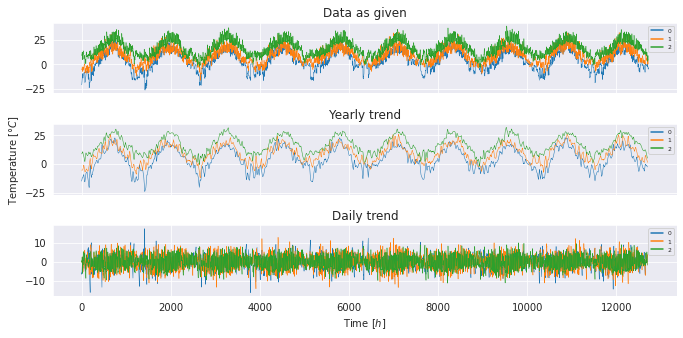

In [11]:
_fig, axes = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=plt.figaspect(1 / 2))
sns.lineplot(data=npa, ax=axes[0], dashes=False, lw=0.5)
axes[0].set_title("Data as given")

sns.lineplot(data=mnpa, ax=axes[1], dashes=False, lw=0.5)
axes[1].set_title("Yearly trend")
axes[1].set_ylabel("Temperature $[°C]$")

sns.lineplot(data=npa[:-N + 1] - mnpa, ax=axes[2], dashes=False, lw=0.5)
axes[2].set_title("Daily trend")
axes[2].set_xlabel("Time $[h]$")

plt.tight_layout()

# Project Tasks <a name="project-tasks"></a>

## 1. Split the time series into a train set containing approximately the first 8 years, and a test set containing the last 2 years. <a name="train-test-split"></a>

In [12]:
pivot = int(0.8 * len(npa))

raw_train_data, raw_test_data = npa[:pivot], npa[pivot:]

raw_train_data.shape, raw_test_data.shape

((10176, 3), (2544, 3))

### We also modify the data to allow for better training. The same modifications can be applied to any new incoming data, or reversed on the original data, so they do not influence our ability to predict real temperatures.

First, detrend the data. This is useful because
1. our models may assume stationarity
2. we do not want effects like global climate change to influence our model weights.

In [13]:
train_data = detrend(raw_train_data, axis=0)
test_data = detrend(raw_test_data, axis=0)

Then, normalize to zero mean and unit variance based on the training set. This is useful because
1. It allows us to sensibly initialize model weights
2. Model weights (and thus gradients) will remain within a normalized range, smoothing training

In [14]:
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

train_data = (train_data - mean[None]) / std[None]
test_data = (test_data - mean[None]) / std[None]

Show the modified data

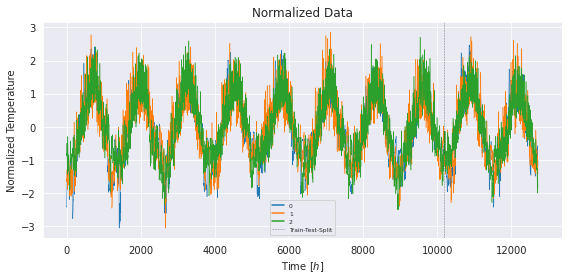

In [15]:
plt.figure(figsize=plt.figaspect(1 / 2))
data = np.concatenate((train_data, test_data), axis=0)
sns.lineplot(data=data, dashes=False, lw=0.5)
plt.axvline(len(train_data), color="black", alpha=0.5, lw=0.5, ls="--", label="Train-Test-Split")

plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")
plt.title("Normalized Data")
plt.legend()

plt.tight_layout()

## 2. Implement a linear latent space model <a name="linear-model"></a>

consisting of a latent VAR(1):
$$
z_{t + 1} = A z_t + \epsilon_t , \quad \epsilon_t \sim \mathcal{N}(0, \Sigma) , \quad z_0 \sim \mathcal{N}(\mu_0, \Sigma)
$$

coupled with a linear observation equation:
$$
x_t = B z_t + \eta_t , \quad \eta_t \sim \mathcal{N}(0, \Gamma)
$$

This model is trained with the Expectation-Maximization-algorithm.

The E-Step consists of the Kalman-Filter-Smoother equation from sheet 6.

The equations for the M-step were derived in the sheets 4 and 5:
$$
\begin{align}
    A &= \left(\sum_{t=2}^T\mathbb{E}[z_t z_{t-1}^T]\right)\cdot\left(\sum_{t=1}^{T-1}\mathbb{E}[z_t z_{t}^T]\right)^{-1}, \\
    \Sigma &= \frac{1}{T} \left( \sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T] - A\cdot\sum_{t=2}^T\mathbb{E}[z_t z_{t-1}^T]^T \right), \\
    \mu_0 &= \mathbb{E}[z], \\
    B &= \left(\sum_{t=2}^Tx_t\mathbb{E}[z_t]^T\right)\cdot\left(\sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T]\right)^{-1}, \\
    \Gamma &= \frac{1}{T} \sum_{t=2}^T \left[ x_tx_t^T - \left(x_t\mathbb{E}[z_z]^TB^T + \left(x_t\mathbb{E}[z_z]^TB^T\right)^T\right) + B\mathbb{E}[z_tz_t^T]B^T \right].
\end{align}
$$
In these equations, $\mathbb{E}[z_t]$ equals to the result of the Kalman-Smoother $\tilde{\mu}$, while $\mathbb{E}[z_tz_t^T]=\mathrm{Var}[z_t] + \mathbb{E}[z_t]\mathbb{E}[z_t]^T=\tilde{V}_t + \mathbb{E}[z_t]\mathbb{E}[z_t]^T$, where $\tilde{V}$ is the result of the Kalman-Smoother.

In order to get $\mathbb{E}[z_tz_{t-1}^T]$, we calculate
$$
\begin{align}
    \mathrm{Cov}[z_t,z_{t-1}\mid\{x_t\}_{1,...,T}] &= \tilde{V}_tL_{t-1}^{-1}AV_{t-1}, \\
    \mathbb{E}[z_tz_{t-1}^T] &= \mathrm{Cov}[z_t,z_{t-1}\mid\{x_t\}_{1,...,T}] + \mathbb{E}[z_t]\mathbb{E}[z_{t-1}]^T
\end{align}
$$
in the Kalman-Smoother part.

In [25]:
class VAR:
    """Linear VAR(1) with coupled linear observation equation:
        z(t) = A @ z(t-1) + epsilon(t)
        x(t) = B @ z(t) + eta(t)
        z(0) ~ N(mu0, Sigma)
        epsilon(t) ~ N(0, Sigma), eta(t) ~ N(0, Gamma)
    """

    def __init__(self, A, Sigma, mu0, B, Gamma):
        self.set_parameters(A, Sigma, mu0, B, Gamma)
        self.latent_dim = Sigma.shape[0]
        self.obs_dim = Gamma.shape[0]

    @staticmethod
    def load_from_dict(path):
        """Creates VAR from .npy file containing a dict with the parameters"""
        data = np.load(path, allow_pickle=True)[()]
        return VAR(**data)

    def set_parameters(self, A, Sigma, mu0, B, Gamma):
        """Set new model parameters"""
        self.A = A
        self.Sigma = Sigma
        self.mu0 = mu0
        self.B = B
        self.Gamma = Gamma

    def get_parameters(self):
        """Returns dict with model parameters"""
        return {
            "A": self.A,
            "Sigma": self.Sigma,
            "mu0": self.mu0,
            "B": self.B,
            "Gamma": self.Gamma
        }

    def generate_time_series(self, T, mu0=None):
        """Generates a time series starting from mu0

        Args:
            T: length of time series
            mu0: If None: Use estimated mu0, i.e. start from beginning
                Else: Sample z0 with given mu0

        Returns:
            The tuple (z, x) containing the latent space time
            series z of shape (T, latent_dim) and the
            observed time series x of shape (T, obs_dim)
        """
        z = np.zeros(shape=(T, self.latent_dim))
        x = np.zeros(shape=(T, self.obs_dim))

        # Noise for the latent space transition equation
        epsilon = np.random.multivariate_normal(np.zeros(self.latent_dim), self.Sigma, size=T)
        # Nosie for the observation equation
        eta = np.random.multivariate_normal(np.zeros(self.obs_dim), self.Gamma, size=T)

        # sample z0 using the estimated mu0 or the given mu0
        if mu0 is None:
            z[0] = np.random.multivariate_normal(self.mu0, self.Sigma)
        else:
            z[0] = np.random.multivariate_normal(mu0, self.Sigma)

        # Calculate first observed value from the sampled z0
        x[0] = self.B @ z[0] + eta[0]

        # iterate over the remaining time steps
        for t in range(1, T):
            z[t] = self.A @ z[t - 1] + epsilon[t]
            x[t] = self.B @ z[t] + eta[t]

        return z, x

    def estimate_parameters(self, x, E_z, E_zz, E_zz1):
        """Performs the M-Step of the Expectation-Maximization algorithm as given above

        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_zz1 = (E[z_t @ z_{t-1}^T])_t: of shape (T-1, latent_dim, latent_dim)

        Returns:
            Tuple with new estimates of the model parameters in the same order as in __init__, i.e.
            (A, Sigma, mu0, B, Gamma)
        """
        T = len(x)

        # Use np.linalg.solve instead of np.linalg.inv for better precision
        # X = B * A^-1  <=>  X * A = B  <=>  A^T * X^T = B^T
        # => X = solve(A^T, B^T)^T
        #A_new = np.sum(E_zz1, axis=0) @ np.linalg.inv(np.sum(E_zz[:-1], axis=0))
        A_new = np.linalg.solve(np.sum(E_zz[:-1], axis=0).T, np.sum(E_zz1, axis=0).T).T

        Sigma_new = 1 / T * (np.sum(E_zz[1:], axis=0) - A_new @ np.sum(E_zz1, axis=0).T)
        # Make Sigma diagonal. Otherwise it wouldn't necessarily be positive semi-definite
        Sigma_new = np.diag(np.diag(Sigma_new))

        mu0_new = E_z[0]

        sum_t_x_Ez = np.einsum("ij,il->jl", x, E_z)

        #B_new = sum_t_x_Ez @ np.linalg.inv(np.sum(E_zz, axis=0))
        B_new = np.linalg.solve(np.sum(E_zz, axis=0).T, sum_t_x_Ez.T).T

        sum_t_x_Ez_BT = sum_t_x_Ez @ B_new.T
        Gamma_new = 1 / T * (np.einsum("ij,il->jl", x, x) - sum_t_x_Ez_BT - sum_t_x_Ez_BT.T + B_new @ np.sum(E_zz,
                                                                                                             axis=0) @ B_new.T)
        # Make Gamma diagonal. Otherwise it wouldn't necessarily be positive semi-definite
        Gamma_new = np.diag(np.diag(Gamma_new))

        return A_new, Sigma_new, mu0_new, B_new, Gamma_new

    def expected_log_likelihood(self, x, E_z, E_zz, E_zz1):
        """Calculates the expected log-likelihood of this model

        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_zz1 = (E[z_t @ z_{t-1}^T])_t: of shape (T-1, latent_idm, latent_dim)

        Returns:
            The expected log-likelihood
        """
        Sigma_inv = np.linalg.inv(self.Sigma)
        Gamma_inv = np.linalg.inv(self.Gamma)
        T = len(x)

        ell = T * np.linalg.slogdet(self.Sigma)[1] + T * np.linalg.slogdet(self.Gamma)[1]
        ell += np.trace(Sigma_inv @ E_zz[1:], axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.A.T @ Sigma_inv @ E_zz1, axis1=1, axis2=2).sum()
        ell += np.trace(self.A.T @ Sigma_inv @ self.A @ E_zz[:-1], axis1=1, axis2=2).sum()

        ell += np.trace(Gamma_inv @ np.einsum("ij,il->ijl", x, x), axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.B.T @ Gamma_inv @ np.einsum("ij,il->ijl", x, E_z), axis1=1, axis2=2).sum()
        ell += np.trace(self.B.T @ Gamma_inv @ self.B @ E_zz, axis1=1, axis2=2).sum()

        return -ell / 2.

In [6]:
def Kalman_Filter_Smoother(x, A, Sigma, mu0, B, Gamma, L0):
    """Performs E-Step using the Kalman-Filter-Smoother equation

    Args:
        x: observed time series of shape (T, obs_dim)
        (A, Sigma, mu0, B, Gamma): Parameter of the model
        L0: initial condition for the covariance matrix.

    Returns:
        mu: estimated means of the Filter-part of shape (T, latent_dim)
        V: estimated covariances of the Filter-part of shape (T, latent_dim, latent_dim)
        mu_tilde: estimated means of the Smoother-part of shape (T, latent_dim)
        V_tilde: estimated covariances of the Smoother-part of shape (T, latent_dim, latent_dim)
        V_tt1: estimated covariances with time lag, i.e. cov[z_t, z_{t-1}] of the Smoother-part of shape (T, latent_dim, latent_dim)
    """
    # Initialize all variables
    p = Sigma.shape[0]
    q = Gamma.shape[0]
    T = len(x)
    K = np.zeros(shape=(T, p, q))
    L = np.zeros(shape=(T, p, p))
    mu = np.zeros(shape=(T, len(mu0)))
    V = np.zeros(shape=(T, p, p))
    mu_tilde = np.zeros(shape=mu.shape)
    V_tilde = np.zeros(shape=V.shape)
    V_tt1 = np.zeros(shape=V.shape)  # = cov_theta[z_t,z_{t-1} | {x_t}_{t=1...T}]

    # Kalman Filter

    # First step using initial conditions
    # Use solve instead of inv for higher precision
    # K[0] = L0 @ B.T @ np.linalg.inv((B @ L0 @ B.T + Gamma))
    K[0] = np.linalg.solve((B @ L0 @ B.T + Gamma).T, (L0 @ B.T).T).T
    V[0] = (np.eye(p) - K[0] @ B) @ L0
    L[0] = L0
    mu[0] = mu0 + K[0] @ (x[0] - B @ mu0)

    # loop over the remaining time steps
    for t in range(1, T):
        L[t] = A @ V[t - 1] @ A.T + Sigma
        #K[t] = L[t] @ B.T @ np.linalg.inv((B @ L[t] @ B.T + Gamma))
        K[t] = np.linalg.solve((B @ L[t] @ B.T + Gamma).T, (L[t] @ B.T).T).T
        mu[t] = A @ mu[t - 1] + K[t] @ (x[t] - B @ A @ mu[t - 1])
        V[t] = (np.eye(p) - K[t] @ B) @ L[t]

    # Kalman Smoother

    # first value in the smoother step equals the last value of the filter step
    mu_tilde[-1] = mu[-1]
    V_tilde[-1] = V[-1]

    for t in range(T - 2, -1, -1):
        #J = V[t] @ A.T @ np.linalg.inv(L[t])
        J = np.linalg.solve(L[t + 1].T, (V[t] @ A.T).T).T
        V_tilde[t] = V[t] + J @ (V_tilde[t + 1] - L[t + 1]) @ J.T
        mu_tilde[t] = mu[t] + J @ (mu_tilde[t + 1] - A @ mu[t])
        V_tt1[t + 1] = V_tilde[t + 1] @ J.T

    return mu, V, mu_tilde, V_tilde, V_tt1

In [7]:
def Expectation_Maximization(var, x, expected_log_likelihoods, parameter_differences, parameters, MSE_train, MSE_test,
                             max_iter=100, tol=1e-4, path=None):
    """Performs the Expectation-Maximization algorithm

    Args:
        var: the linear latent space model with linear observation equation
        x: observed time series of shape (T, obs_dim)
        expected_log_likelihoods: List to which the calculated expected log likelihood is appended each iteration
        parameter_differences: This function calculates the maximal absolute parameter difference compared to the previous iteration
        parameters: List of the parameters of each iteration combined into a dict as returned by var.get_parameters()
        MSE_train, MSE_test: Every 10th iteration 10 time series are sampled and calculated with the current model state
            and the averaged mean squared errors for the train and the test set are appended
        max_iter: maximum number of iterations
        path: If None: Save the lists above-mentioned lists to the given folder

    Returns:
        the new VAR model
    """
    ell_prev = 0
    pbar = tqdm(range(max_iter))
    pbar.set_description(f"latent_dim = {var.latent_dim}, iteration {0}")
    train_error = 0
    test_error = 0

    for i in pbar:
        old_params = var.get_parameters()
        # Perform Kalman-Filter-Smoother algorithm using the current parameters
        mu, V, mu_tilde, V_tilde, V_tt1 = Kalman_Filter_Smoother(x=x, L0=var.Sigma, **old_params)

        # Calculate expectations using the results from the Kalman-Smoother
        E_z = mu_tilde
        E_zz = V_tilde + np.einsum("ij,il->ijl", E_z, E_z)
        E_zz1 = V_tt1[1:] + np.einsum("ij,il->ijl", E_z[1:], E_z[:-1])

        # Calculate the new parameters using the expectations and the observed time series
        new_params = var.estimate_parameters(x, E_z, E_zz, E_zz1)
        var.set_parameters(*new_params)

        # Calculate the new expected-log-likelihood
        ell = var.expected_log_likelihood(x, E_z, E_zz, E_zz1)

        # Calculate the maximum absolute parameter difference
        max_parameter_difference = max(
            [np.max(np.abs(new_p - old_p)) for (new_p, old_p) in zip(new_params, old_params.values())])

        # Every 10th iteration (only every 10th for higher speed),
        # generate 10 time series and calculate the averaged MSE-error for the
        # training set and the test set. Since the predictions depend heavily on the sampled z0,
        # we calculate 10 time series and average over those.
        if (i + 1) % 10 == 0:
            generated_time_series = np.array([var.generate_time_series(len(npa))[1] for _ in range(10)])
            generated_time_series_train = generated_time_series[:, :len(raw_train_data), :]
            generated_time_series_test = generated_time_series[:, len(raw_train_data):, :]
            train_error = ((generated_time_series_train - raw_train_data[np.newaxis, :, :]) ** 2).mean()
            test_error = ((generated_time_series_test - raw_test_data[np.newaxis, :, :]) ** 2).mean()
            MSE_train.append(train_error)
            MSE_test.append(test_error)

        pbar.set_description(
            f"latent_dim = {var.latent_dim}, iteration {i + 1}, ell = {ell:.{int(-np.log10(tol))}f}, max param difference = {max_parameter_difference:.{int(-np.log10(tol))}f}, MSE_train = {train_error:.4f}, MSE_test = {test_error:.4f}")

        # append new parameters, expected-log-likelihood and parameter differences to the given lists
        parameters.append(var.get_parameters())
        expected_log_likelihoods.append(ell)
        parameter_differences.append(max_parameter_difference)

        ell_prev = ell

        # Save the parameters and lists (but only every 10th iteration for higher speed)
        if path is not None and i % 10 == 0 and i > 0:
            np.save(path + "A_params.npy", np.array([p["A"] for p in parameters]))
            np.save(path + "Sigma_params.npy", np.array([p["Sigma"] for p in parameters]))
            np.save(path + "mu0_params.npy", np.array([p["mu0"] for p in parameters]))
            np.save(path + "B_params.npy", np.array([p["B"] for p in parameters]))
            np.save(path + "Gamma_params.npy", np.array([p["Gamma"] for p in parameters]))
            np.save(path + "expected_log_likelihoods.npy", expected_log_likelihoods)
            np.save(path + "parameter_differences.npy", parameter_differences)
            np.save(path + "MSE_train.npy", MSE_train)
            np.save(path + "MSE_test.npy", MSE_test)

    return var

Do a hyperparameter search on the latent dimension:

In [8]:
def find_optimal_latent_dim(latent_dims, continue_training, max_iter):
    """Trains a VAR for multiple latent dimensions and saves parameters, expected_log_likelihoods,
    parameter_differences, MSE_train and MSE_test

    Args:
        latent_dims: List containing the latent dimensions for which a VAR should be trained
        continue_training: loads the parameters from the previously trained model and continues training
        max_iter: maximum number of iteration
    """
    T, obs_dim = raw_train_data.shape
    for latent_dim in latent_dims:
        if continue_training:
            # load parameters and other lists to continue training
            A_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy"))
            Sigma_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy"))
            mu0_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy"))
            B_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy"))
            Gamma_params = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy"))
            expected_log_likelihoods = list(
                np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy"))
            parameter_differences = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy"))
            MSE_train = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy"))
            MSE_test = list(np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy"))

            # convert 5 arrays of parameters to list of dict of parameters
            parameters = [
                {
                    "A": A,
                    "Sigma": Sigma,
                    "mu0": mu0,
                    "B": B,
                    "Gamma": Gamma
                }
                for (A, Sigma, mu0, B, Gamma) in zip(A_params, Sigma_params, mu0_params, B_params, Gamma_params)
            ]

            # MSE_train and MSE_test is only saved every 10th iteration
            # Therefore round down to the nearest ten and redo the iteration steps
            index = len(MSE_train) * 10
            parameters = parameters[:index]
            expected_log_likelihoods = expected_log_likelihoods[:index]
            parameter_differences = parameter_differences[:index]

            var = VAR(**parameters[-1])

        else:
            # create (new) folder for the parameters and lists
            pl.Path(f"./var_params/latent_dim_{latent_dim:03d}").mkdir(parents=True, exist_ok=True)

            # Initialize parameters.
            # All parameters are chosen small in order to avoid overflows during the first iterations
            # A_initial is chosen as identity + noise, Sigma and Gamma are diagonal with small positive values
            A_initial = np.eye(latent_dim) * 1e-2 + np.random.uniform(-1e-3, 1e-3, size=(latent_dim, latent_dim))
            Sigma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=latent_dim))
            mu0_initial = np.random.uniform(-1e-3, 1e-3, size=latent_dim)
            B_initial = np.random.uniform(-1e-3, 1e-3, size=(obs_dim, latent_dim))
            Gamma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=obs_dim))

            var = VAR(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial)

            expected_log_likelihoods = []
            parameter_differences = []
            parameters = []
            MSE_train = []
            MSE_test = []

        # train the VAR with Expectation-Maximization
        var = Expectation_Maximization(var, raw_train_data, expected_log_likelihoods, parameter_differences, parameters,
                                       MSE_train, MSE_test, max_iter=max_iter,
                                       path=f"./var_params/latent_dim_{latent_dim:03d}/")

        # convert list of dicts to 5 lists of parameters
        A_params = np.array([p["A"] for p in parameters])
        Sigma_params = np.array([p["Sigma"] for p in parameters])
        mu0_params = np.array([p["mu0"] for p in parameters])
        B_params = np.array([p["B"] for p in parameters])
        Gamma_params = np.array([p["Gamma"] for p in parameters])

        # save parameters and other lists
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy", A_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy", Sigma_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy", mu0_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy", B_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy", Gamma_params)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy", expected_log_likelihoods)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy", parameter_differences)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy", MSE_train)
        np.save(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy", MSE_test)

In [61]:
find_optimal_latent_dim([4, 8, 16, 32, 64], False, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

MemoryError: Unable to allocate 318. MiB for an array with shape (10176, 64, 64) and data type float64

In [13]:
find_optimal_latent_dim([64], True, 160)

9840


  0%|          | 0/160 [00:00<?, ?it/s]

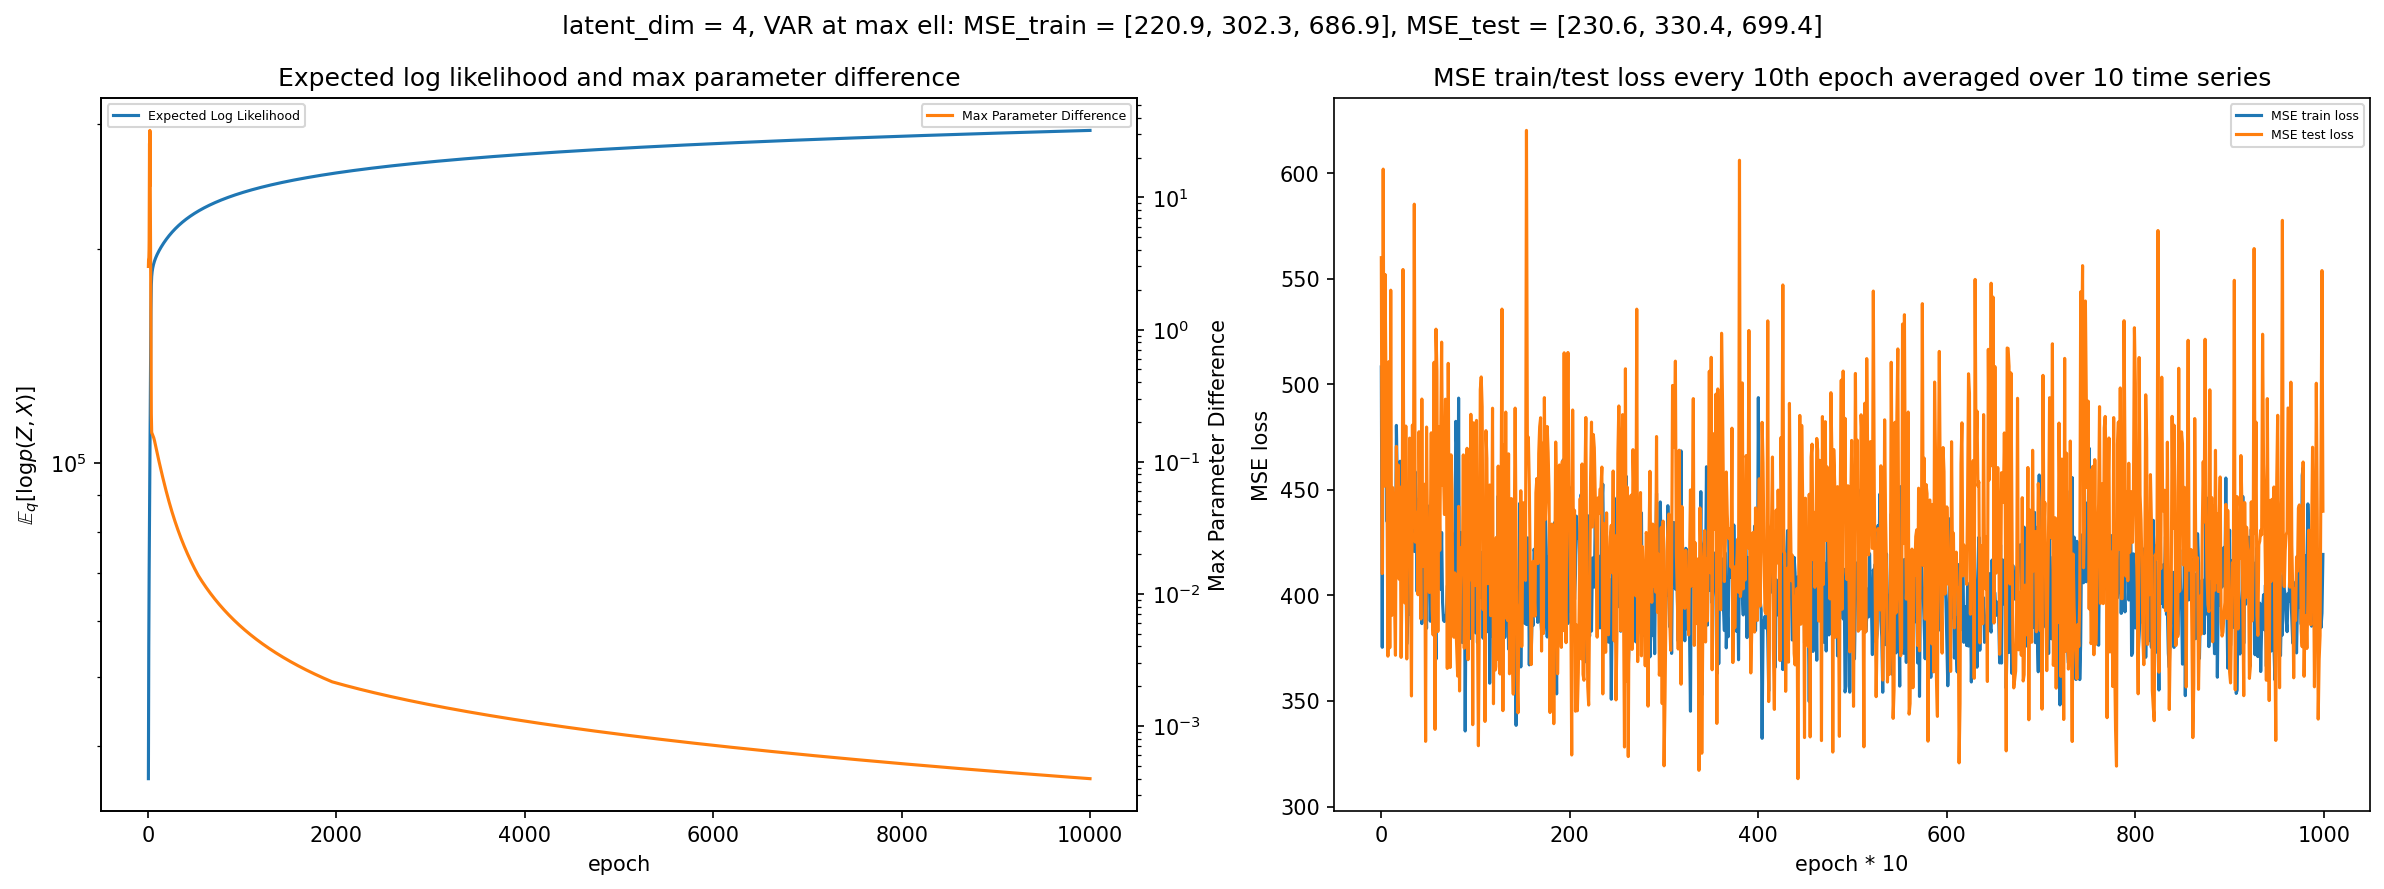

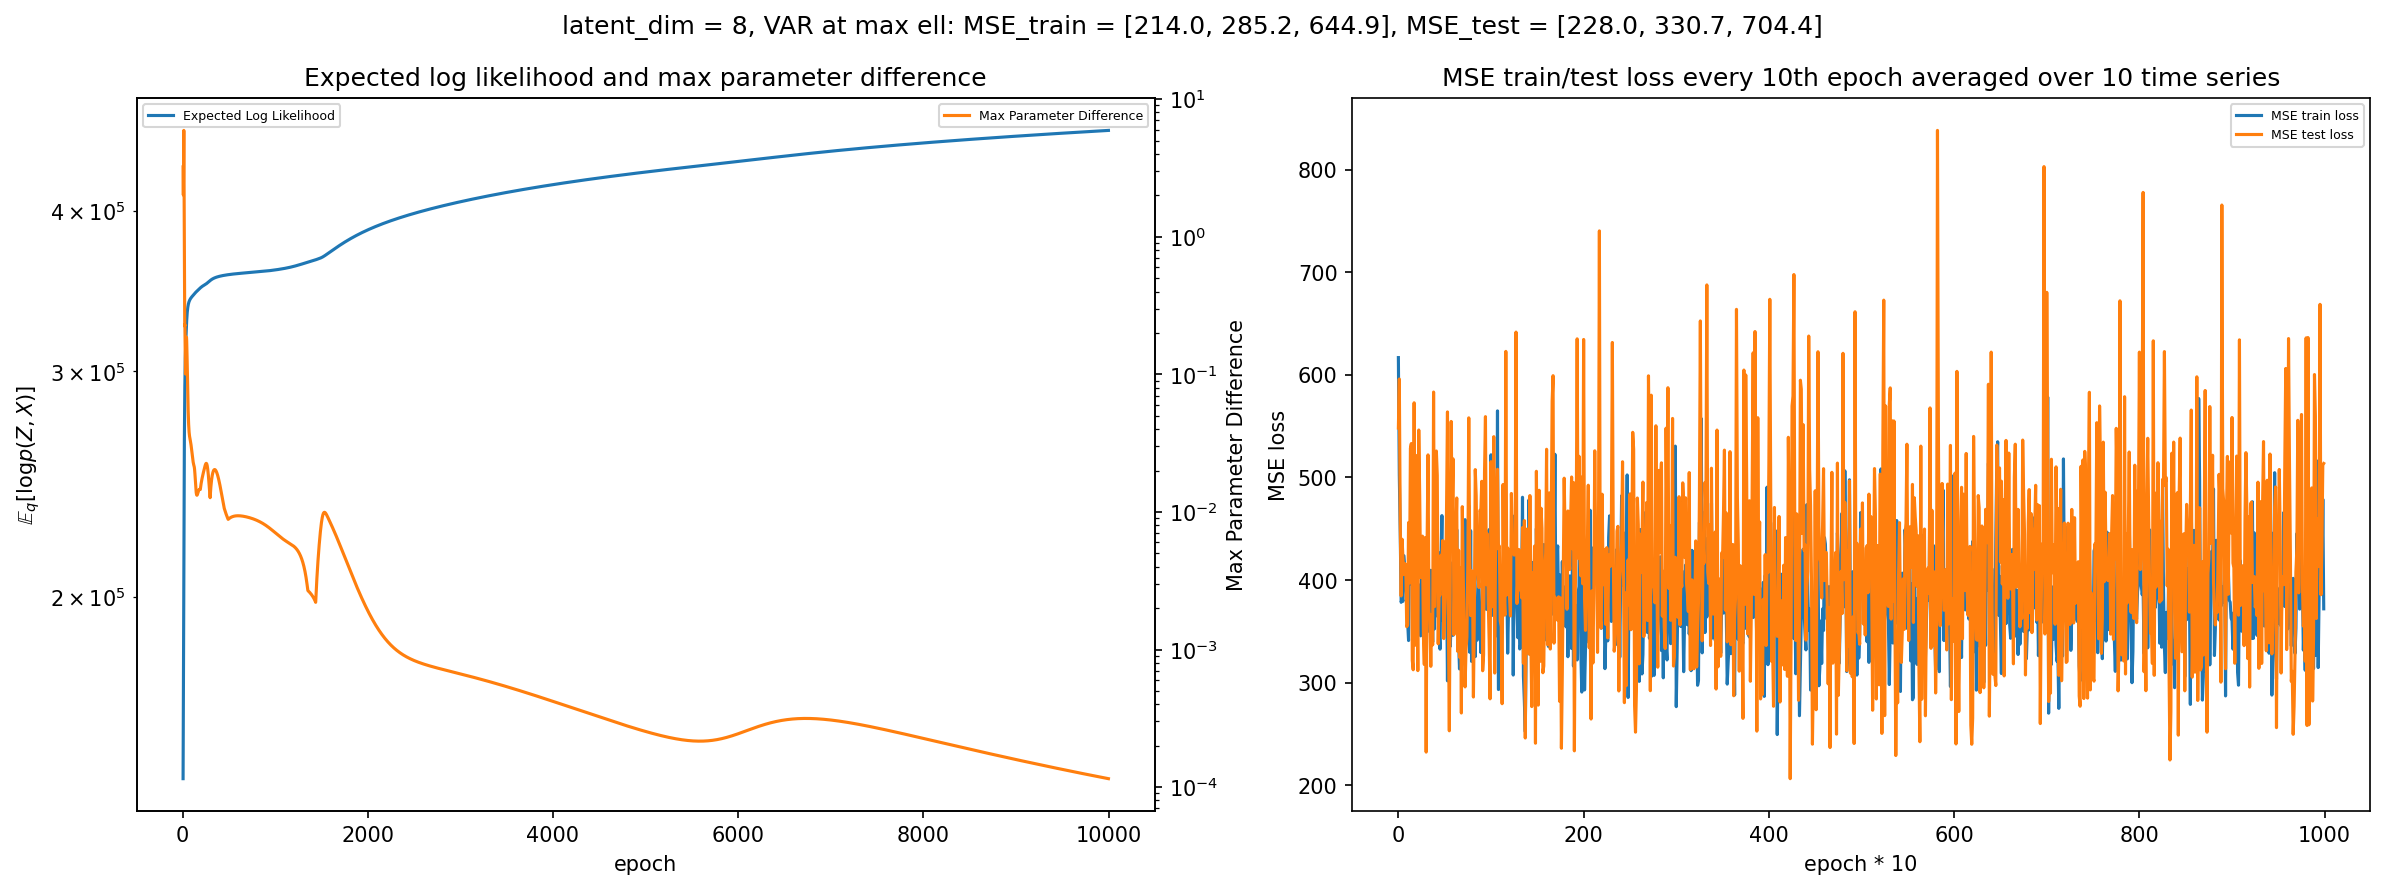

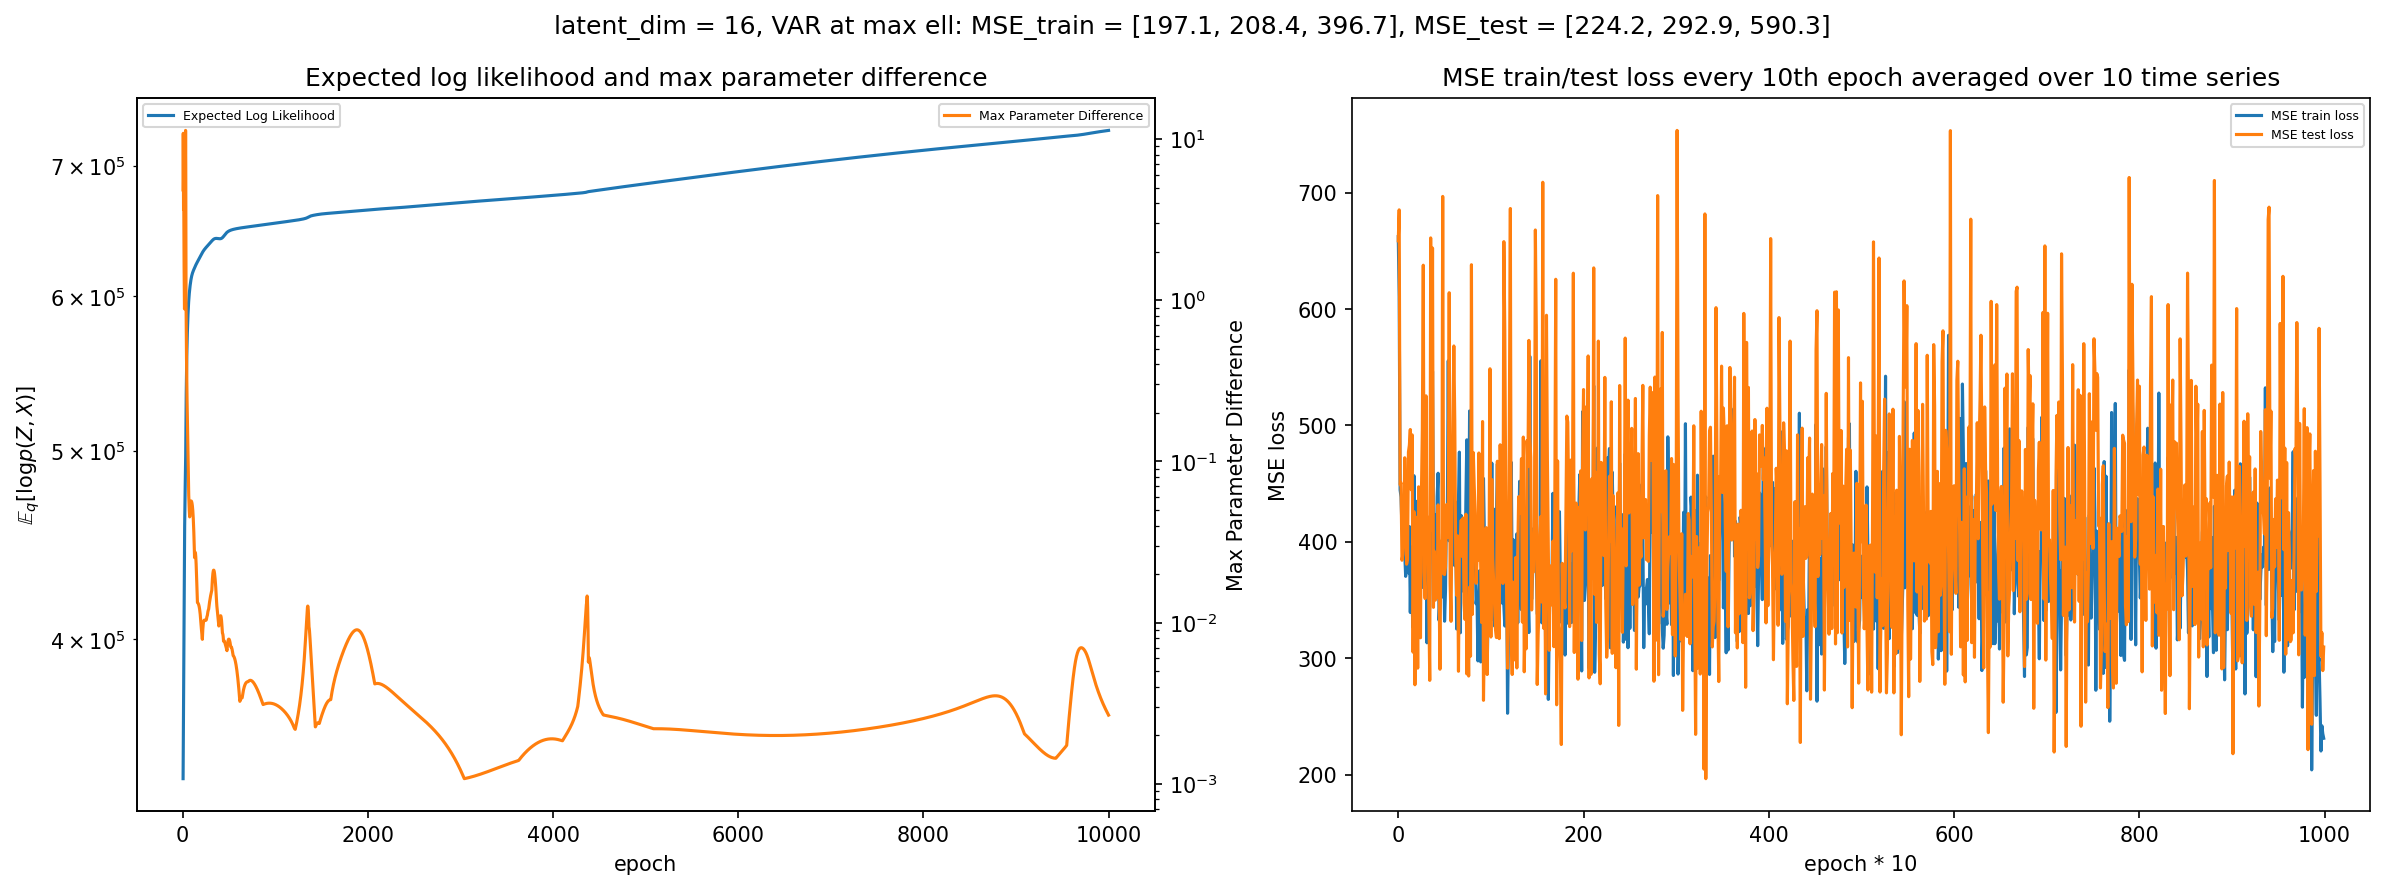

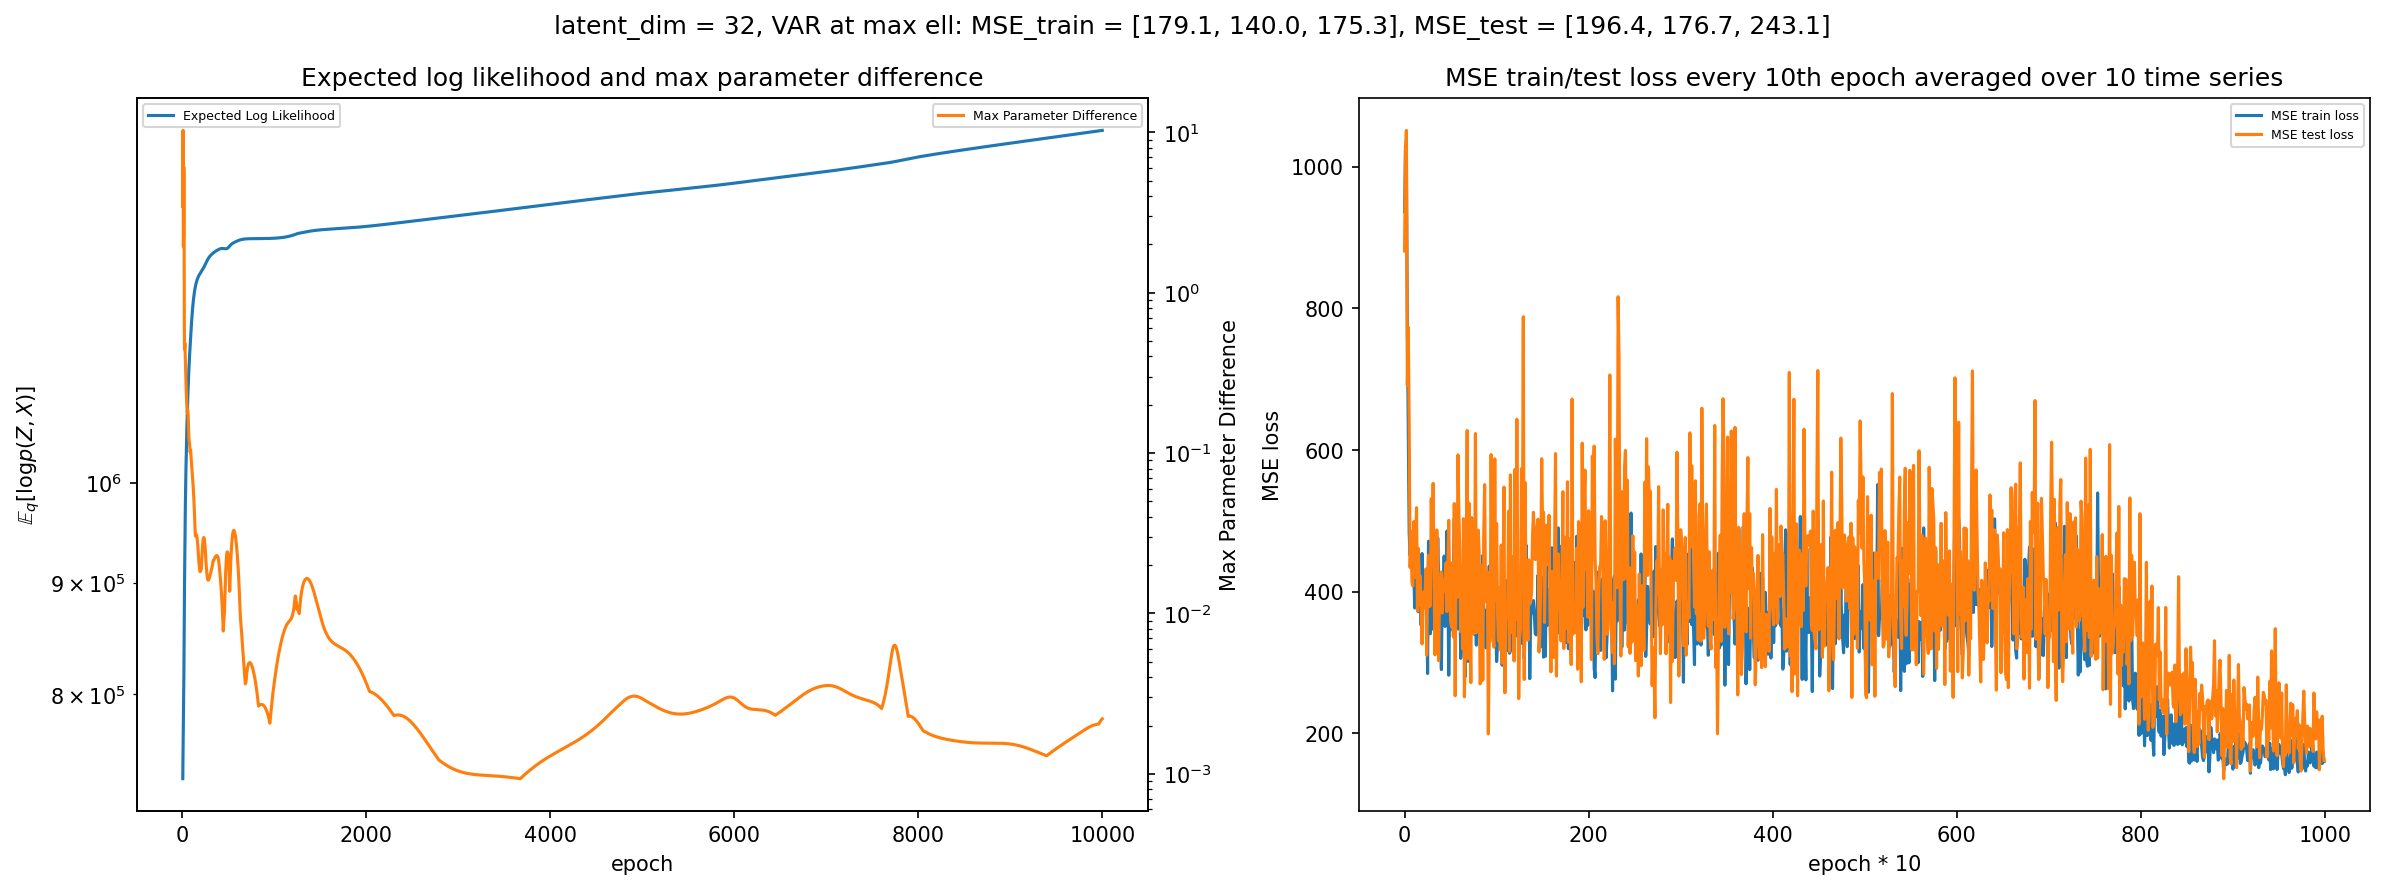

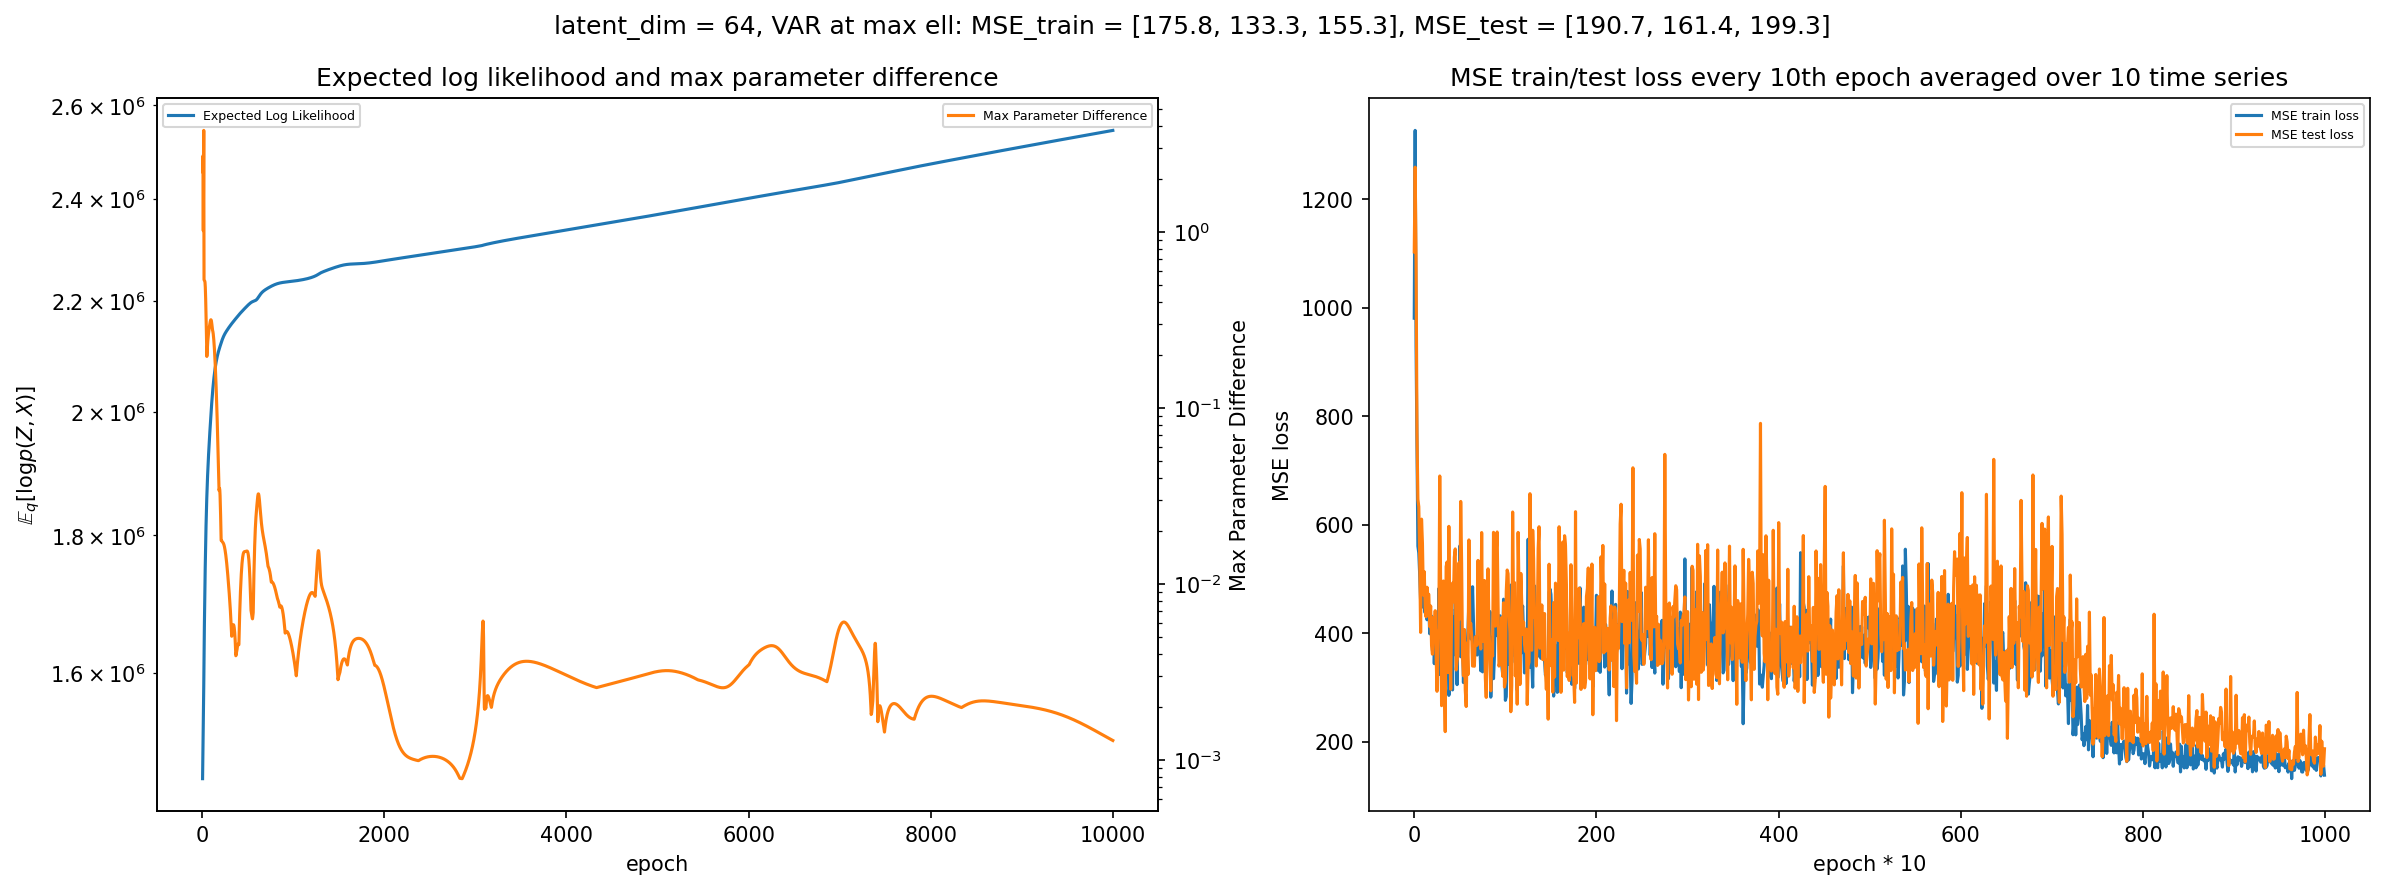

In [61]:
for latent_dim in [4, 8, 16, 32, 64]:
    # Load the parameters and lists, choose the model with highest expected-log-likelihood
    A_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy")
    Sigma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy")
    mu0_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy")
    B_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy")
    Gamma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy")
    expected_log_likelihoods = np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy")
    parameter_differences = np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy")
    MSE_train = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy")
    MSE_test = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy")
    index = np.argmax(expected_log_likelihoods)

    # Plot the expected-log-likelihood and the parameter differences on the left side
    # and the MSE_train and MSE_test on the right side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax1 = axes[0]
    ax2 = ax1.twinx()
    start = 5
    ax1.plot(np.arange(start, len(expected_log_likelihoods)), expected_log_likelihoods[start:], 'C0',
             label="Expected Log Likelihood")
    ax2.plot(np.arange(start, len(expected_log_likelihoods)), parameter_differences[start:], 'C1',
             label="Max Parameter Difference")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel(r"$\mathbb{E}_q[\log p(Z,X)]$")
    ax2.set_ylabel("Max Parameter Difference")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_title("Expected log likelihood and max parameter difference")
    ax1.legend(loc=2)
    ax2.legend(loc=1)

    axes[1].plot(MSE_train, label="MSE train loss")
    axes[1].plot(MSE_test, label="MSE test loss")
    axes[1].set_xlabel("epoch * 10")
    axes[1].set_ylabel("MSE loss")
    axes[1].set_title("MSE train/test loss every 10th epoch averaged over 10 time series")
    axes[1].legend()

    # Calculate 1000 time series using the best VAR, calculate the MSE-error for the training set and test set
    # and add them to the title
    var = VAR(A_params[index], Sigma_params[index], mu0_params[index], B_params[index], Gamma_params[index])
    generated_time_series = np.array([var.generate_time_series(len(npa))[1] for _ in range(1000)])
    generated_time_series_train = generated_time_series[:, :len(raw_train_data), :]
    generated_time_series_test = generated_time_series[:, len(raw_train_data):, :]
    train_error = ", ".join([str(n) for n in np.round(
        ((generated_time_series_train - raw_train_data[np.newaxis, :, :]) ** 2).mean(axis=1).mean(axis=0), 1)])
    test_error = ", ".join([str(n) for n in np.round(
        ((generated_time_series_test - raw_test_data[np.newaxis, :, :]) ** 2).mean(axis=1).mean(axis=0), 1)])

    plt.suptitle(f"latent_dim = {latent_dim}, VAR at max ell: MSE_train = [{train_error}], MSE_test = [{test_error}]")

    plt.tight_layout()
    plt.show()



In the plots, we can see that the MSE-losses for the latent-dimensions 4, 8 and 16 are fluctuating around 400, while the MSE-losses of the VARs with 32 and 64 dimensions start to decrease again after $\sim7500$ iterations and converge to $\sim150-200$. Due to the high number of iterations needed and the high duration of the iteration, we are not able to further increase the latent dimension. Since the MSE-loss for the 64-dimensional VAR is slightly lower than the MSE-loss of the 32-dimensional VAR, we use this model in the following.

In [13]:
# load the best model and save the parameters again as a dict.
latent_dim = 64
A_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/A_params.npy")
Sigma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Sigma_params.npy")
mu0_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/mu0_params.npy")
B_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/B_params.npy")
Gamma_params = np.load(f"./var_params/latent_dim_{latent_dim:03d}/Gamma_params.npy")
expected_log_likelihoods = np.load(f"./var_params/latent_dim_{latent_dim:03d}/expected_log_likelihoods.npy")
parameter_differences = np.load(f"./var_params/latent_dim_{latent_dim:03d}/parameter_differences.npy")
MSE_train = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_train.npy")
MSE_test = np.load(f"./var_params/latent_dim_{latent_dim:03d}/MSE_test.npy")
index = np.argmax(expected_log_likelihoods)

optimal_params = {
    "A": A_params[index],
    "Sigma": Sigma_params[index],
    "mu0": mu0_params[index],
    "B": B_params[index],
    "Gamma": Gamma_params[index]
}
np.save("VAR_optimal_params.npy", optimal_params)

In [44]:
var_optimal = VAR.load_from_dict("VAR_optimal_params.npy")

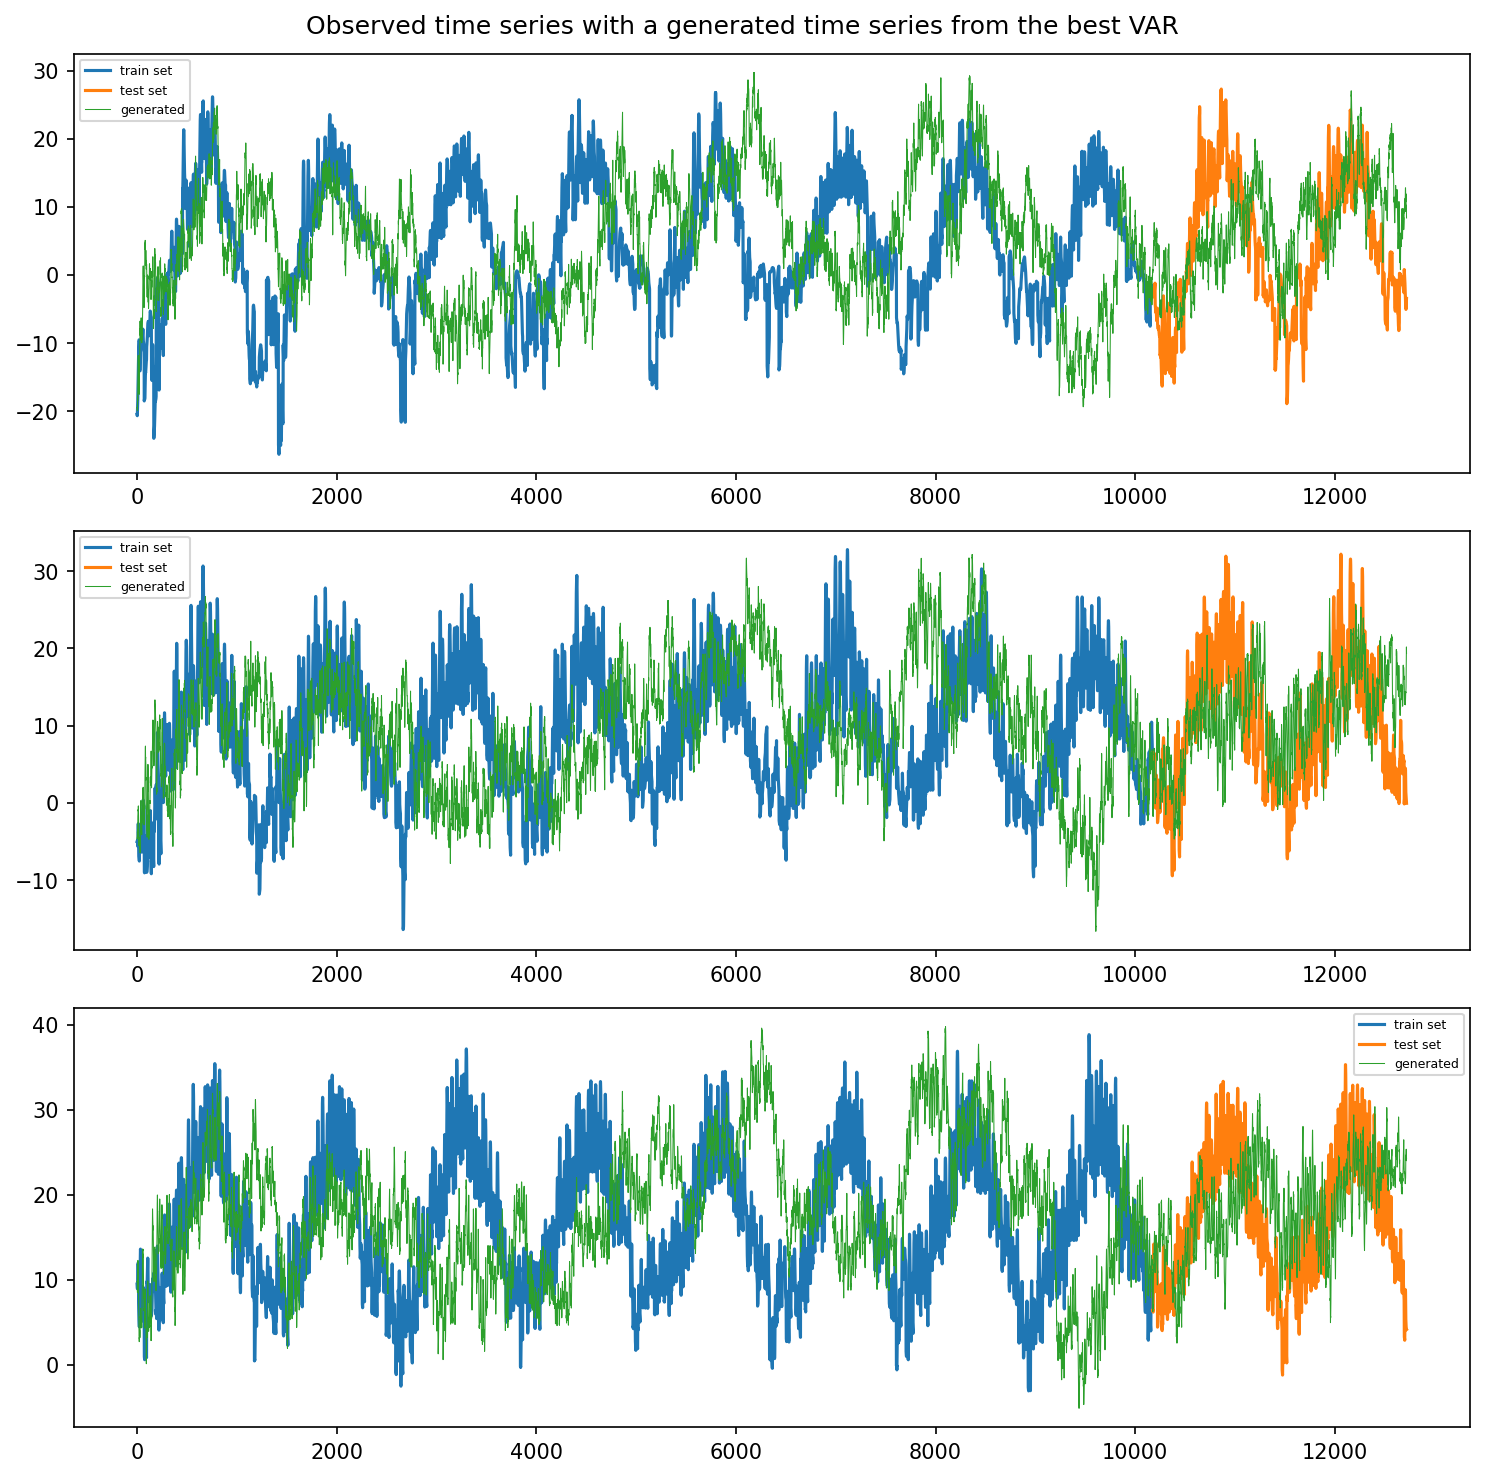

In [56]:
ts = var_optimal.generate_time_series(len(npa))[1]

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t_train = np.arange(len(raw_train_data))
t_test = np.arange(len(raw_train_data), len(raw_train_data) + len(raw_test_data))
for i in range(3):
    axes[i].plot(t_train, raw_train_data[:, i], c="C0", label="train set")
    axes[i].plot(t_test, raw_test_data[:, i], c="C1", label="test set")
    axes[i].plot(ts[:, i], c=f"C2", lw=.5, label="generated")
    axes[i].legend()
plt.suptitle("Observed time series with a generated time series from the best VAR")
plt.tight_layout()
plt.show()

From this example plot, one can see, that in some regions, the generated time series is close to the true values, while in other regions it deviates more strongly and does not predict the true values.

In [46]:
# The VAR starts from z0 by sampling with mu0. In order to begin from any point in the training series, we need a suitible
# mu for that point. One could sample a z0 using mu0, iterate until that point and use the last z as new starting point.
# But the quality of the predictions heavily depend on the sampled z0. Sampling multiple z0s and iterate all of them
# and average the resulting zs would not work, since they might differ.
# Instead, we perform the Kalman-Filter-Smoother once using the optimal parameters and choose
# mu_tilde[t] as initial mean of the latent state.
def draw_initial_conditions(var, num):
    T = len(raw_train_data)
    _, _, mu_tilde, _, _ = Kalman_Filter_Smoother(raw_train_data, L0=var.Sigma, **var.get_parameters())
    initial_time_points = np.random.choice(np.arange(T), size=num, replace=False)
    return initial_time_points, mu_tilde[initial_time_points]

(2544, 3)


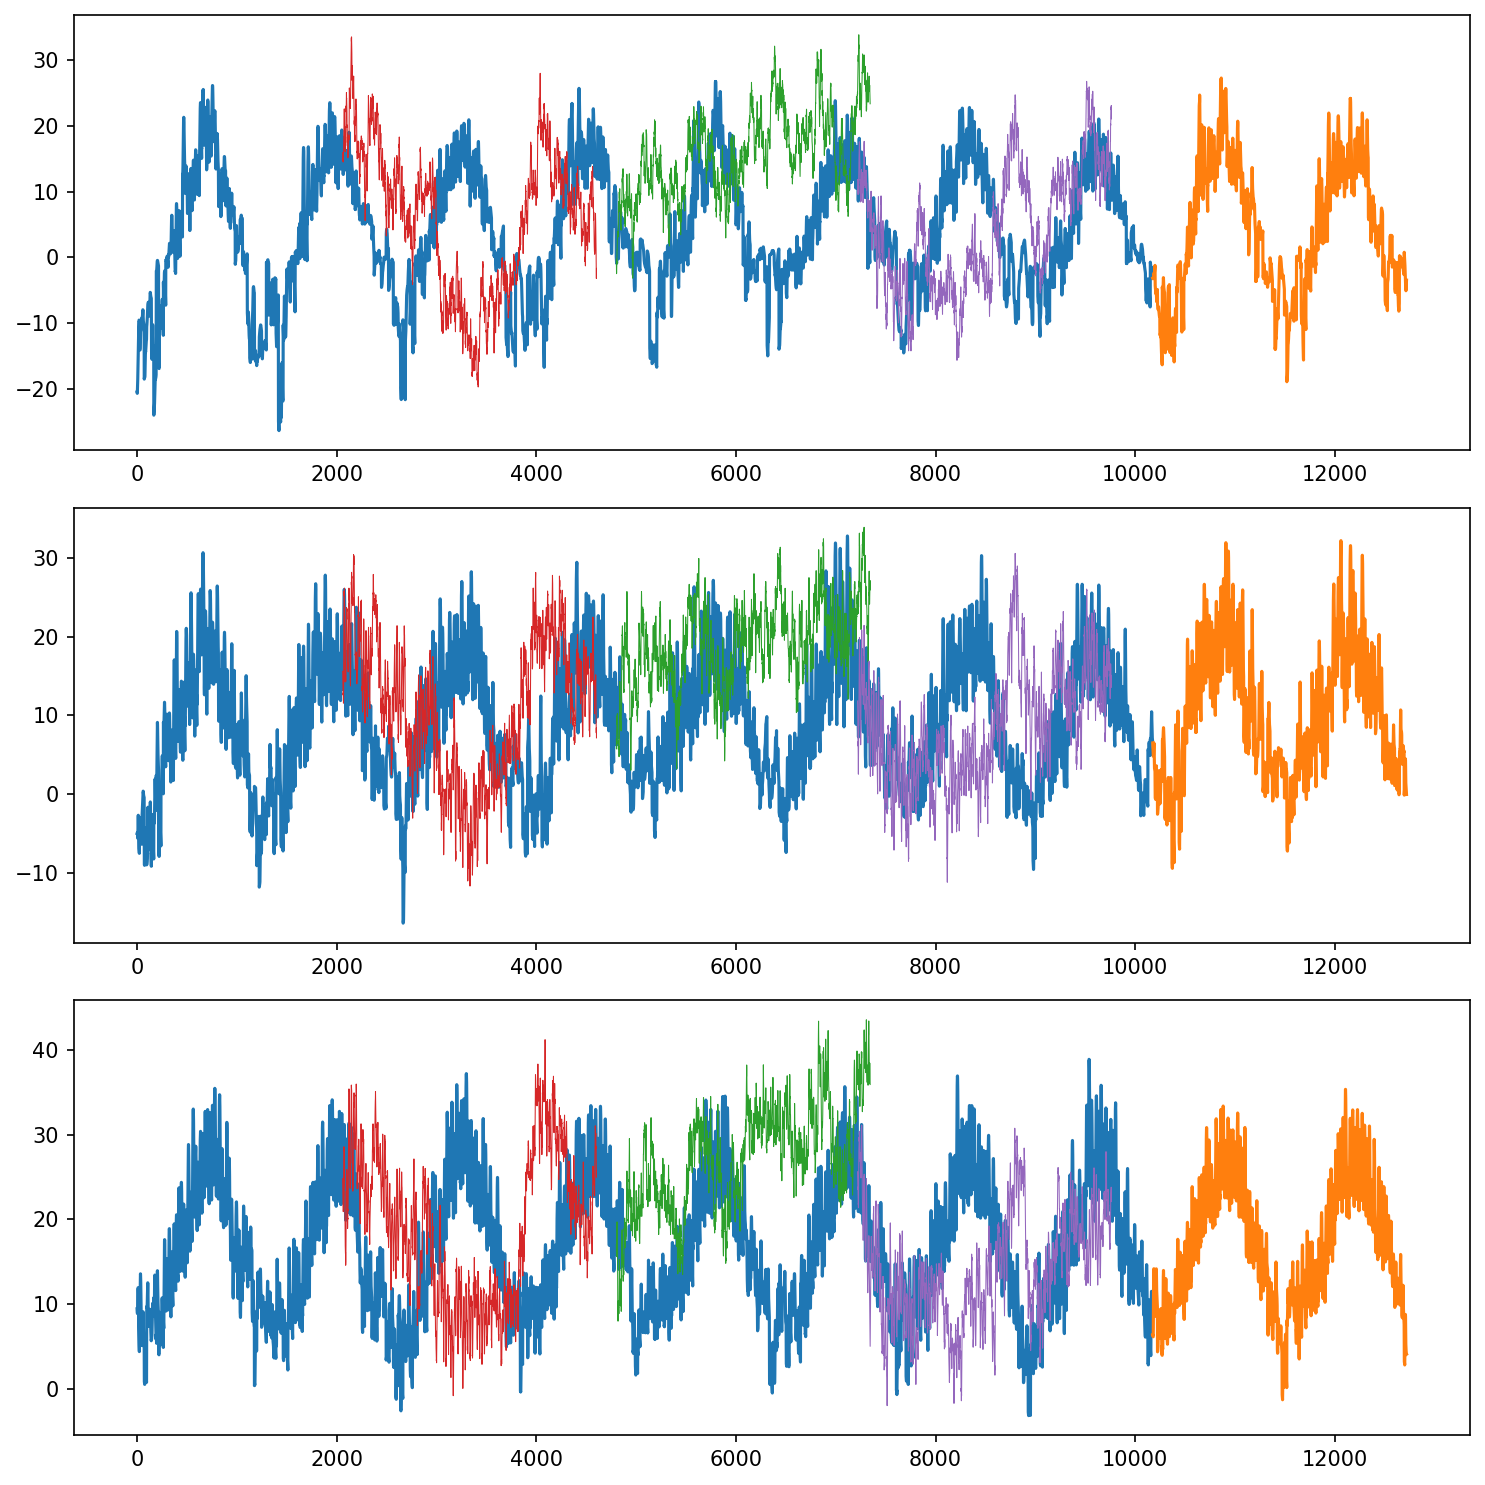

In [47]:
initial_time_points, mu0s = draw_initial_conditions(var_optimal, 3)
time_series_length = len(raw_train_data) // 4
generated_time_series = [var_optimal.generate_time_series(time_series_length, mu0=mu0)[1] for mu0 in mu0s]
print(generated_time_series[0].shape)

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t_train = np.arange(len(raw_train_data))
t_test = np.arange(len(raw_train_data), len(raw_train_data) + len(raw_test_data))
for i in range(3):
    axes[i].plot(t_train, raw_train_data[:, i], c="C0")
    axes[i].plot(t_test, raw_test_data[:, i], c="C1")
    for j in range(len(generated_time_series)):
        axes[i].plot(np.arange(initial_time_points[j], initial_time_points[j] + time_series_length),
                     generated_time_series[j][:, i], c=f"C{j + 2}", lw=.5)
plt.tight_layout()
plt.show()

Create some summary and results dataframes for analysis later

In [17]:
summary = pd.DataFrame(columns=["model_name", "train_mse", "validation_mse"])
countries = ["FI", "DE", "GR"]
columns = pd.MultiIndex.from_product([["actual"], countries])
train_predictions = pd.DataFrame(data=train_data, columns=columns.copy())
validation_predictions = pd.DataFrame(data=test_data, columns=columns.copy())

In [18]:
summary.head()

Empty DataFrame
Columns: [model_name, train_mse, validation_mse]
Index: []

In [19]:
train_predictions.head()

actual                    
         FI        DE        GR
0 -2.406694 -1.589150 -0.804909
1 -2.425204 -1.579953 -0.839934
2 -2.428143 -1.580719 -0.861752
3 -2.410838 -1.578165 -0.869990
4 -2.364361 -1.583728 -0.874615

### 3. Use a deterministic LSTM coupled with a fully connected observation layer and optimize it with backpropagation through time <a name="lstm"></a>

First, we define a custom dataset for the LSTM

In [20]:
class TimeSeriesDataset(Dataset):
    """
    Time Series Dataset where each item is a fixed-length sequence within the time series
    """

    def __init__(self, time_series: torch.Tensor, sequence_length: int):
        """
        Initialize the Time Series Dataset
        :param time_series: torch.Tensor of shape (T, ...)
        :param sequence_length: Integer defining the sequence length of each item (sub-time-series)
        """
        self.time_series = time_series
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time_series) - 2 * self.sequence_length + 1

    def __getitem__(self, item: int):
        """
        :return:
            x: input sub-sequence
            y: target sub-sequence of same length, directly after x
        """
        x = self.time_series[item:item + self.sequence_length]
        y = self.time_series[item + self.sequence_length:item + 2 * self.sequence_length]
        return x, y


train_data = torch.tensor(train_data, dtype=torch.float32)
val_data = torch.tensor(test_data, dtype=torch.float32)

We use `pytorch-lightning` to define the model, train loop, etc.

In [21]:
class LSTM(lightning.LightningModule):
    """
    Lightning Module which contains a Long Short-Term Memory RNN
    This Module defines
    - The LSTM neural network along with an observation layer
    - The loss criterion
    - The train loop
    - The validation loop
    - The train and validation datasets
    - The train and validation dataloaders
    - The optimizers and learning rate schedulers
    - Several train callbacks
    """

    def __init__(self, train_data: torch.Tensor, val_data: torch.Tensor, **hparams) -> None:
        """
        Initialize the LSTM LightningModule
        :param train_data: Time series tensor which is passed to a TimeSeriesDataset
        :param val_data: Time series tensor which is passed to a TimeSeriesDataset
        :param hparams: Other hyperparameters (see below)
        """
        super().__init__()
        # save all hyperparameters so that we can trivially load models with the correct configuration
        self.save_hyperparameters(hparams, ignore=["train_data", "val_data"])

        # construct the time series datasets
        self.train_data = TimeSeriesDataset(train_data, self.hparams.sequence_length)
        self.val_data = TimeSeriesDataset(val_data, self.hparams.sequence_length)

        # construct LSTM with given hyperparameters
        self.lstm = nn.LSTM(self.hparams.input_size, self.hparams.hidden_size, self.hparams.num_layers,
                            dropout=self.hparams.dropout, batch_first=True)
        # we set a fixed observation net depth; width is based on hyperparameters
        self.observation_net = nn.Sequential(
            nn.Linear(self.hparams.hidden_size, self.hparams.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hparams.hidden_size, self.hparams.input_size),
        )

        # initial predictions close to 0 are good, since we normalized the data
        self.observation_net[-1].weight.data.fill_(0.0)
        self.observation_net[-1].bias.data.fill_(0.0)

        # define the loss criterion used in training
        self.loss = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward step of the LSTM and observation layer
        :param x: Input Tensor (batch of time series)
        :return: Output Tensor (batch of predicted observations)
        """
        z, _ = self.lstm.forward(x)
        y = self.observation_net.forward(z)

        return y

    def training_step(self, batch: torch.Tensor, batch_idx: torch.Tensor) -> torch.Tensor:
        """
        Define a single training step for the LSTM and observation layer
        We just need to calculate and return the loss, lightning handles backpropagation and everything else
        This method will be called in trainer.fit() later
        :param batch: Input Tensor (batch of time series)
        :param batch_idx: Index of Batch (unused)
        :return: Scalar Loss Tensor
        """
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss(yhat, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Define a single validation step for the LSTM and observation layer
        We just want to calculate and log the loss, otherwise this is equivalent to training_step
        :param batch: Input Tensor (batch of time series)
        :param batch_idx: Index of Batch (unused)
        :return: None
        """
        x, y = batch
        yhat = self.forward(x)
        loss = self.loss(yhat, y)

        self.log("val_loss", loss)

    def predict(self, x: torch.Tensor, hx=None, steps: int = 1):
        """
        Run multiple predictions and concatenate
        :param x: Input Tensor (batch of time series)
        :param hx: Hidden State
        :param steps: Number of steps to predict
        :return: Concatenated predictions, shape will be (batch_size, steps * self.hparams.sequence_length, ...)
        """
        predictions = []
        x = x[:, -self.hparams.sequence_length:].to(self.device)

        for _ in range(steps):
            z, hx = self.lstm.forward(x, hx)
            x = self.observation_net(z).detach()

            predictions.append(x)

        return torch.cat(predictions, dim=1)

    def forecast(self, steps: int = 1):
        """
        Forecast a number of prediction steps starting from the end of the training set
        :param steps: Number of steps to forecast
        :return: Concatenated forecasts, shape will be (1, steps * self.hparams.sequence_length, ...)
        """
        return self.predict(self.train_data.time_series[None], steps=steps).squeeze()

    def simulate(self, batch_size: int = 1, steps: int = 1, data: torch.Tensor = None):
        """
        Simulate a new time series, drawing initial conditions randomly from the training set
        :param batch_size: Number of time series to generate
        :param steps: Number of steps to generate for each time series
        :return: Concatenated time series, shape will be (batch_size, steps * self.hparams.sequence_length, ...)
        """
        if data is None:
            data = self.train_data.time_series

        starts = torch.randint(low=0, high=len(data) - self.hparams.sequence_length, size=(batch_size,))
        stops = starts + self.hparams.sequence_length
        # unfortunately, this cannot be done without a loop
        xs = []
        for start, stop in zip(starts, stops):
            x = data[start:stop]
            xs.append(x)
        x = torch.stack(xs, dim=0)

        return self.predict(x, steps=steps)

    def configure_optimizers(self):
        """
        Configure optimizers and lr schedulers for lightning
        """
        match self.hparams.optimizer.lower():
            case "adam":
                optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate,
                                             weight_decay=self.hparams.weight_decay)
            case "rmsprop":
                optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.learning_rate,
                                                weight_decay=self.hparams.weight_decay)
            case _:
                raise ValueError(f"Optimizer {self.hparams.optimizer} is not supported.")

        lr_warmup = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_warmup_milestones,
                                                         self.hparams.lr_warmup_gamma)
        lr_step = torch.optim.lr_scheduler.MultiStepLR(optimizer, self.hparams.lr_milestones, self.hparams.lr_gamma)
        lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler([
            lr_warmup,
            lr_step,
        ])
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

    def configure_callbacks(self):
        """
        Configure callbacks for lightninng
        """
        return [
            # this saves the best and last model (best is defined by validation loss)
            lightning.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True),
            # this logs the learning rate, so we can view it in tensorboard
            lightning.callbacks.LearningRateMonitor(),
            # SWA is a form of zero-cost regularization
            lightning.callbacks.StochasticWeightAveraging(swa_epoch_start=self.hparams.swa_start,
                                                          swa_lrs=self.hparams.swa_lr, device=None),
        ]

    def train_dataloader(self):
        """
        Configure and return the train dataloader for lightning
        """
        return DataLoader(
            dataset=self.train_data,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
        )

    def val_dataloader(self):
        """
        Configure and return the validation dataloader for lightning
        """
        return DataLoader(
            dataset=self.val_data,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=4,
        )

We run a hyperparameter search using `ray[tune]`'s `ASHA`, which runs multiple configurations sampled randomly from the parameter space and stops poorly performing trials early to save resources. We come up with the following results:


| Parameter Name         | Description                                                                         | Effect                                                                                                                                       | Searched Space      | Optimal Value  |
|------------------------|-------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------|---------------------|----------------|
| `input_size`           | Given by the number of tracked temperatures                                         | -                                                                                                                                            | -                   | 3              |
| `hidden_size`          | Defines the size of the latent space for the LSTM                                   | Large Latent spaces can capture the target function better, but require more memory, are slower to train and prone to overfit                | 60 - 360[^1]        | 120            |
| `num_layers`           | Defines the number of layers for the LSTM                                           | Similar to `hidden_size`                                                                                                                     | 2 - 6[^1]           | 4              |
| `dropout`              | Controls the Dropout probability for within the LSTM                                | Regularization, counteracts overfitting                                                                                                      | 0 - 0.5             | ~0.4           |
| `weight_decay`         | Controls strength of $L^2$ regularization                                           | Regularization, counteracts overfitting                                                                                                      | 1e-4 - 1e-2         | ~3e-4          |
| `batch_size`           | Number of sub-sequences to train on in parallel                                     | Larger batch sizes smooth the loss landscape, but slow training since more computations must be made for the same number of gradient updates | 4 - 64              | 4              |
| `optimizer`            | Algorithm to optimize the parameter set                                             | Adam might not converge for some parameter sets, RMSprop is suited for use with gradients of greatly different magnitudes                    | "adam", "rmsprop"   | "adam"         |
| `learning_rate`        | Defines the (default) step-size of the optimizer                                    | Larger learning rates speed training, but the network may not converge at all if the learning rate is too big                                | 1e-4 - 1e-2         | ~1e-4          |
| `gradient_clip`        | Defines the value at which gradient-norm will be clipped                            | May help smooth very noisly loss landscapes                                                                                                  | -                   | None           |
| `sequence_length`      | Defines the length of the sub-sequence the RNN trains on and predicts               | Must be large enough to capture periodicities in the dataset, but we are limited by the size of the train and validation set.                | 1 month - 12 months | 7 months (672) |
| `lr_warmup_milestones` | Defines epochs at which to increase the `learning_rate` by factor `lr_warmup_gamma` | May help with numerical stability at the start of training                                                                                   | -                   | []             |
| `lr_warmup_gamma`      | See `lr_warmup_milestones`                                                          | See `lr_warmup_milestones`                                                                                                                   | -                   | 10.0           |
| `lr_milestones`        | Defines epochs at which to decrease the `learning_rate` by factor `lr_gamma`        | Helps push the network deeper into the local minimum it found at the end of training                                                         | -                   | [40, 45]       |
| `lr_gamma`             | See `lr_milestones`                                                                 | See `lr_milestones`                                                                                                                          | -                   | 0.1            |
| `swa_start`            | Defines epoch at which to start stochastic weight averaging                         | Regularizes weights at the end of training, leading to better test error                                                                     | -                   | 50             |
| `swa_lr`               | Defines the learning rate to use for stochastic weight averaging                    | SWA allows using higher LR                                                                                                                   | -                   | 1e-3           |

[^1]: Optimal parameters may lie outside of this range, but were not searched due to memory constraints.

These are the optimal hyperparameters:

In [22]:
hparams = dict(
    input_size=npa.shape[-1],
    hidden_size=120,
    num_layers=2,
    dropout=0.4,
    weight_decay=1e-4,
    batch_size=4,
    optimizer="adam",
    learning_rate=1e-4,
    gradient_clip=None,
    sequence_length=7 * 4 * 24,
    lr_warmup_milestones=[],
    lr_warmup_gamma=10.0,
    lr_milestones=[40, 45],
    lr_gamma=0.1,
    swa_start=50,
    swa_lr=1e-3,
)

Here is the code to run the hyperparameter search:

In [23]:
def train(hparams, metrics, max_epochs=16, gpus=-1):
    """
    This is the train function used by ray[tune]
    """
    model = LSTM(train_data, val_data, **hparams)

    # use a different save_dir for the logger
    logger = loggers.TensorBoardLogger(
        save_dir=tune.get_trial_dir(), name="", version="."
    )

    # define the lightning trainer with a Tune Report Callback
    trainer = lightning.Trainer(
        max_epochs=max_epochs,
        gpus=gpus,
        callbacks=[
            TuneReportCallback(metrics=metrics, on="validation_end")
        ],
        logger=logger,
        enable_progress_bar=False,
    )

    trainer.fit(model)

    return model

In [24]:
def tune_hparams(config, metrics, num_samples=256, max_epochs=16, cpus_per_trial=3, gpus_per_trial=0.33, resume=False):
    """
    Tune hparams from the given config using ASHA
    :param config: Defines the parameter space
    :param metrics: metrics to evaluate each parameter set
    :param num_samples: how often to sample from the parameter space
    :param max_epochs: number of max epochs to train per parameter set
    :param cpus_per_trial: number of cpu cores to use for each trial (must be positive)
    :param gpus_per_trial: number of gpus to use for each trial (can be fractional)
    :return: Parameter analysis results
    """

    # run for at most 3 minutes
    # in testing we already saw significant overfit after 3 minutes of training for most parameter sets
    scheduler = tune.schedulers.AsyncHyperBandScheduler(
        time_attr="time_total_s",
        max_t=3 * 60,
        grace_period=60,
        reduction_factor=4,
    )

    # report progress in a notebook-friendly way
    reporter = tune.JupyterNotebookReporter(
        overwrite=True,
        parameter_columns=list(config.keys()),
        metric_columns=list(metrics.keys()) + ["training_iteration"],
    )

    # bind the train function to given parameters
    train_fn = tune.with_parameters(train, metrics=metrics, max_epochs=max_epochs, gpus=int(np.ceil(gpus_per_trial)))

    # tune.run needs this as a dict
    resources_per_trial = dict(cpu=cpus_per_trial, gpu=gpus_per_trial)

    # run the hyperparameter search
    analysis = tune.run(
        train_fn,
        resources_per_trial=resources_per_trial,
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        local_dir="ray_results",
        name="tune_asha",
        resume=resume,
    )

    return analysis

Define the space for the parameter search:

In [25]:
# metrics to evaluate parameter configurations
metrics = dict(
    loss="val_loss",
)

config = hparams.copy()
config["optimizer"] = tune.choice(["adam", "rmsprop"])
config["hidden_size"] = tune.choice([60, 120, 240, 360])
config["num_layers"] = tune.choice([1, 2, 4, 6])
config["learning_rate"] = tune.loguniform(1e-4, 1e-2)
# sample between one month (4 weeks * 24 hours) and 12 months, quantized by months
config["sequence_length"] = tune.qrandint(4 * 24, 12 * 4 * 24, 4 * 24)
# sample logarithmically between 4 and 256 with base 4, quantized by steps of 4
config["batch_size"] = tune.qlograndint(4 ** 1, 4 ** 4, 4, 4)
config["dropout"] = tune.uniform(0.0, 0.5)
config["weight_decay"] = tune.loguniform(1e-4, 1e-2)

Uncomment this to run the parameter search. Note that running the full search may take several hours (around 12 hours, tested on a Ryzen 7 5800X CPU with an RTX 2080 GPU). If a trial errors (e.g. due to limited memory), you can restart the search with `resume="ERRORED_ONLY"`.

In [26]:
# analysis = tune_hparams(config, metrics, gpus_per_trial=0.33, resume=False)
# hparams = analysis.best_config
# print(f"Best hyperparameters found were: {hparams}")

Fully train the model with the best hyperparameters. First show the tensorboard widget to track training:

In [27]:
% load_ext tensorboard
% tensorboard --logdir lightning_logs

Launching TensorBoard...

Training takes around 5-20 minutes, depending on number of epochs used (usually 20 are sufficient).

In [28]:
model = LSTM(train_data, val_data, **hparams)

trainer = lightning.Trainer(
    max_epochs=20,
    gpus=-1,
)

model.train()
trainer.fit(model)

# we're done with training, so disable autograd for the rest of the notebook
torch.autograd.set_grad_enabled(False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | lstm            | LSTM       | 176 K 
1 | observation_net | Sequential | 14.9 K
2 | loss            | MSELoss    | 0     
-----------------------------------------------
191 K     Trainable params
0         Non-trainable params
191 K     Total params
0.764     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Swapping scheduler `ChainedScheduler` for `SWALR`


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
# load the best model
model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, train_data=train_data,
                                   val_data=val_data)
model.eval()

LSTM(
  (lstm): LSTM(3, 120, num_layers=2, batch_first=True, dropout=0.4)
  (observation_net): Sequential(
    (0): Linear(in_features=120, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=3, bias=True)
  )
  (loss): MSELoss()
)

In [33]:
# get train set predictions
x = model.train_data.time_series[:model.hparams.sequence_length][None]
steps = int(np.ceil(len(train_predictions) / model.hparams.sequence_length))
tp = torch.cat((x, model.predict(x, steps=steps)), dim=1).squeeze()

# truncate predictions to fit dataframe
tp = tp[:len(train_predictions)]

# same for the validation set
steps = int(np.ceil(len(validation_predictions) / model.hparams.sequence_length))
vp = model.forecast(steps=steps)
vp = vp[:len(validation_predictions)]

# find (non-normalized) train and validation mse
train_residuals = tp - model.train_data.time_series
validation_residuals = vp - model.val_data.time_series

std = torch.from_numpy(std)
train_mse = torch.mean((std * train_residuals) ** 2).numpy()
validation_mse = torch.mean((std * validation_residuals) ** 2).numpy()

# add to dataframes (this is convoluted because of multi-indexing, but makes for nice dataframes in the end)
s_entry = pd.DataFrame.from_dict({"model_name": ["LSTM"], "train_mse": [train_mse], "validation_mse": [validation_mse]})
columns = pd.MultiIndex.from_product([["LSTM"], countries])
tp_entry = pd.DataFrame(data=tp.detach().cpu().numpy(), columns=columns.copy())
vp_entry = pd.DataFrame(data=vp.detach().cpu().numpy(), columns=columns.copy())

summary = pd.concat((summary, s_entry), axis=0)
train_predictions = pd.concat((train_predictions, tp_entry), axis=1)
validation_predictions = pd.concat((validation_predictions, vp_entry), axis=1)

TypeError: expected np.ndarray (got Tensor)

### 4. Use your two models to make a prediction of the last 2 years. <a name="test-set"></a>

First, check the fit on the train set

Text(0.5, 1.0, 'Training Set Fit')

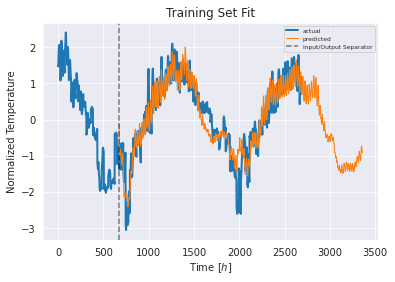

In [34]:
steps = 4

x = model.train_data.time_series[None, model.hparams.sequence_length:(1 + steps) * model.hparams.sequence_length]

xhat = x[:, :model.hparams.sequence_length]
yhat = model.predict(xhat, steps=steps)
yhat = yhat.detach().cpu().numpy()

plt.plot(np.arange(x.shape[1]), x[0, :, 0], lw=2, label="actual")
plt.plot(np.arange(xhat.shape[1], xhat.shape[1] + yhat.shape[1]), yhat[0, :, 0], lw=1, label="predicted")
plt.axvline(model.hparams.sequence_length, color="black", alpha=0.5, ls="--", label="Input/Output Separator")
plt.xlabel("Time $[h$]")
plt.ylabel("Normalized Temperature")
plt.legend()
plt.title("Training Set Fit")

And now on the validation set (last 2 years). We compare the fit for different timescales:

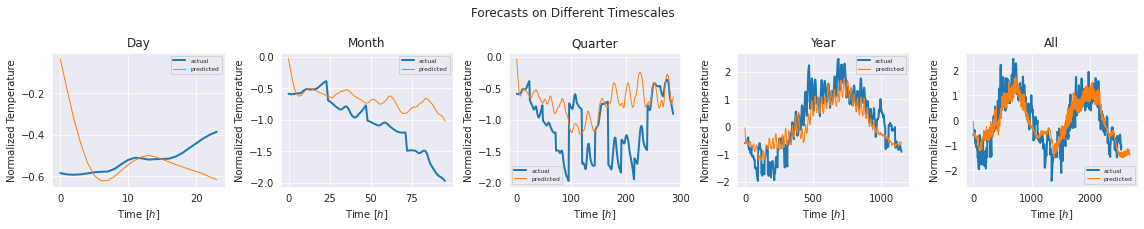

In [35]:
steps = int(round(len(val_data) / model.hparams.sequence_length))
yhat = model.forecast(steps)

titles = ["Day", "Month", "Quarter", "Year", "All"]
endpoints = [24, 4 * 24, 3 * 4 * 24, 12 * 4 * 24, None]

fig, axes = plt.subplots(1, len(titles), figsize=plt.figaspect(1 / len(titles)))

for ax, title, endpoint in zip(axes, titles, endpoints):
    ax.plot(val_data[:endpoint, 0], lw=2, label="actual")
    ax.plot(yhat[:endpoint, 0], lw=1, label="predicted")
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel("Time $[h]$")
    ax.set_ylabel("Normalized Temperature")

fig.suptitle("Forecasts on Different Timescales")
plt.tight_layout()
plt.show()

It appears the LSTM fits well to the yearly cycle, and also captures a daily cycle, but does not fit well on short timescales.

### Compare their Mean Squared Errors

The LSTM is the clear winner in terms of MSE.

In [36]:
summary

model_name                             train_mse  \
0       LSTM  tensor(44.2418, dtype=torch.float64)   

                         validation_mse  
0  tensor(17.4660, dtype=torch.float64)

### Make an expressive plot summarizing your results

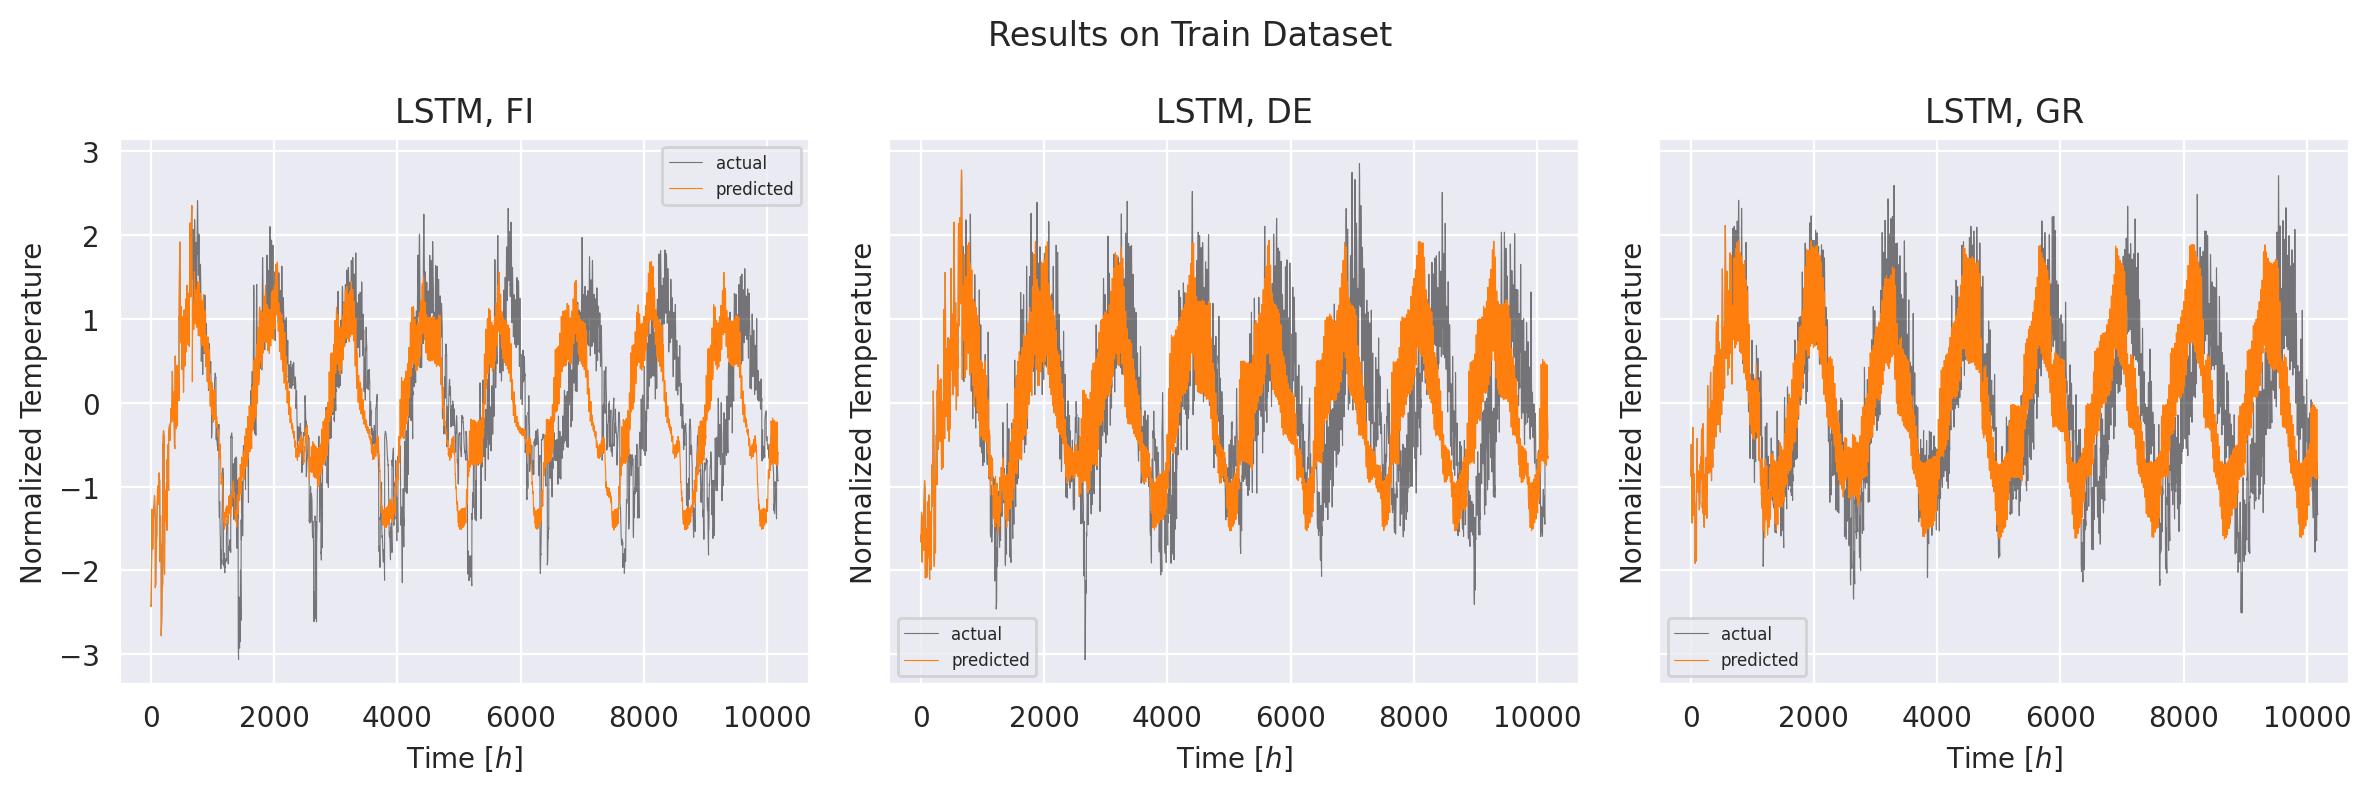

In [37]:
# number of models
nrows = len(summary)
# number of countries
ncols = len(countries)

plt.rc("figure", dpi=200)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=plt.figaspect(nrows / ncols), sharex="all", sharey="row",
                         squeeze=False)

for row, model_name in enumerate(summary["model_name"]):
    for col, country in enumerate(countries):
        ax = axes[row, col]

        actual = train_predictions[("actual", country)]
        predicted = train_predictions[(model_name, country)]
        ax.plot(actual, color="black", alpha=0.5, lw=0.4, label="actual")
        ax.plot(predicted, color="C1", lw=0.4, label="predicted")

        ax.set_title(f"{model_name}, {country}")
        ax.set_xlabel("Time $[h]$")
        ax.set_ylabel("Normalized Temperature")
        ax.legend()

fig.suptitle("Results on Train Dataset")
plt.tight_layout()
plt.savefig("results_train.png")
plt.show()

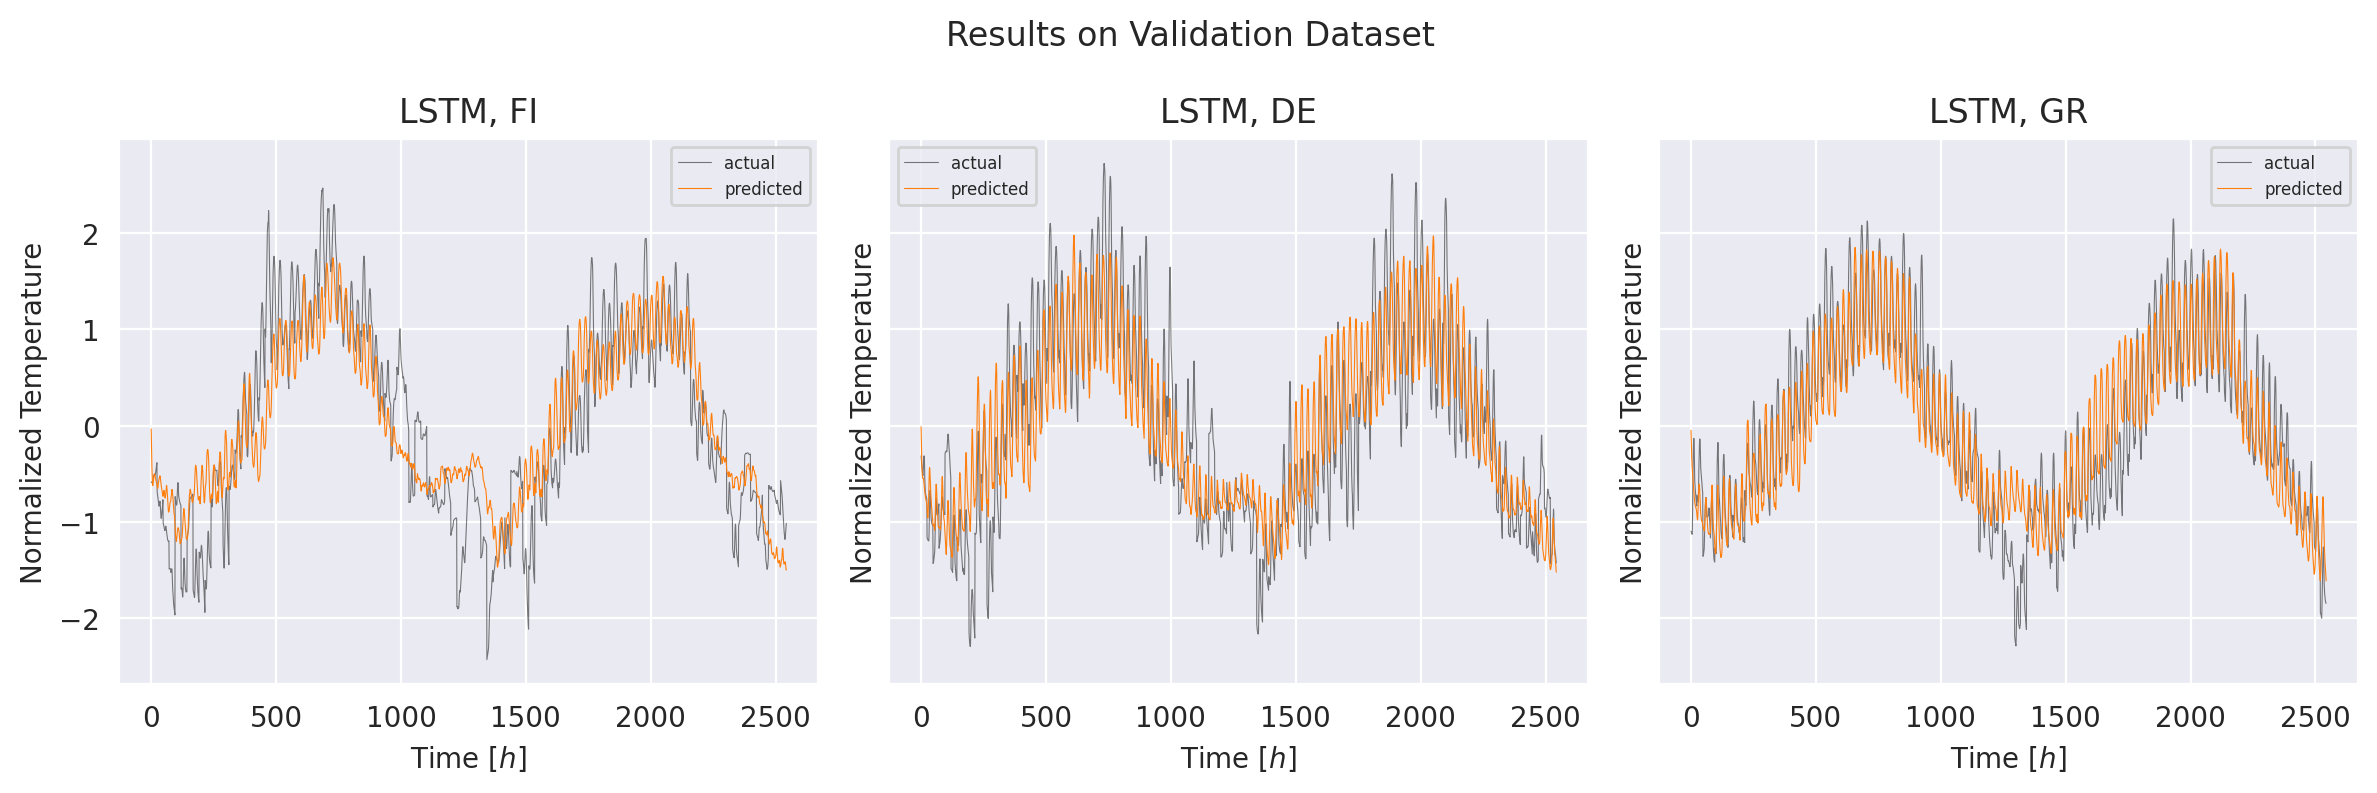

In [38]:
# number of models
nrows = len(summary)
# number of countries
ncols = len(countries)

plt.rc("figure", dpi=200)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=plt.figaspect(nrows / ncols), sharex="all", sharey="row",
                         squeeze=False)

for row, model_name in enumerate(summary["model_name"]):
    for col, country in enumerate(countries):
        ax = axes[row, col]

        actual = validation_predictions[("actual", country)]
        predicted = validation_predictions[(model_name, country)]
        ax.plot(actual, color="black", alpha=0.5, lw=0.4, label="actual")
        ax.plot(predicted, color="C1", lw=0.4, label="predicted")

        ax.set_title(f"{model_name}, {country}")
        ax.set_xlabel("Time $[h]$")
        ax.set_ylabel("Normalized Temperature")
        ax.legend()

fig.suptitle("Results on Validation Dataset")
plt.tight_layout()
plt.savefig("results_val.png")
plt.show()

### 5. Check the DS reconstruction capabilities of your models with the provided powerspectrum correlation metric. <a name="psc"></a>

#### 5.1. Implement a routine which draws several random initial conditions from any point in the data and generates time series of length $T$, where $T$ is greater than or equal to one year.

We did this in `model.simulate()`. To simulate at least one year, we need to pass `steps=2` or greater.

In [39]:
ts = model.simulate(steps=2)

ts.shape

torch.Size([1, 1344, 3])

Text(0, 0.5, 'Normalized Temperature')

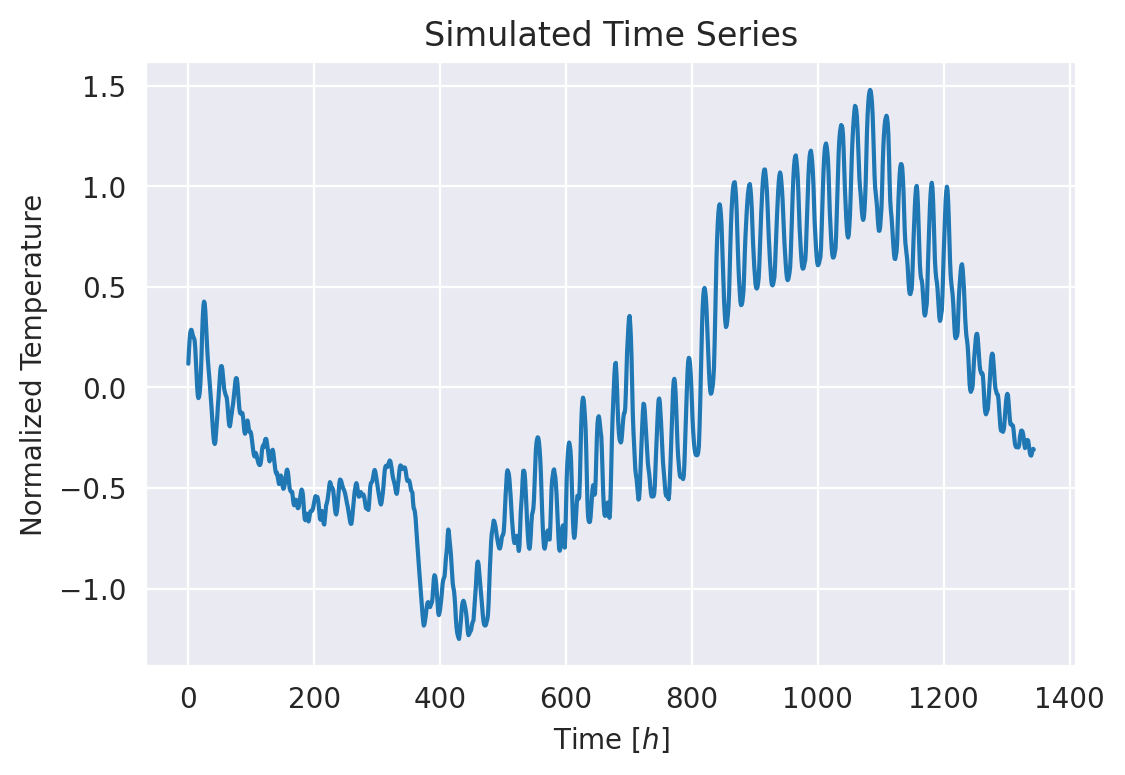

In [40]:
plt.plot(ts[:, :, 0].squeeze())
plt.title("Simulated Time Series")
plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")

Since we want to compare with ground truth, let's copy and modify `model.simulate`:

In [41]:
batch_size = 32
steps = 4

data = torch.cat((model.train_data.time_series, model.val_data.time_series))

starts = torch.randint(low=0, high=len(data) - (steps + 1) * model.hparams.sequence_length, size=(batch_size,))
stops = starts + model.hparams.sequence_length

# unfortunately, this cannot be done without a loop
xs = []
gts = []
for start, stop in zip(starts, stops):
    x = data[start:stop]
    xs.append(x)
    gt = data[stop: stop + steps * model.hparams.sequence_length]
    gts.append(gt)

x = torch.stack(xs, dim=0)
gt = torch.stack(gts, dim=0)

ts = model.predict(x, steps=steps).numpy()

# time series (ts) and ground truth (gt)
ts.shape, gt.shape

((32, 2688, 3), torch.Size([32, 2688, 3]))

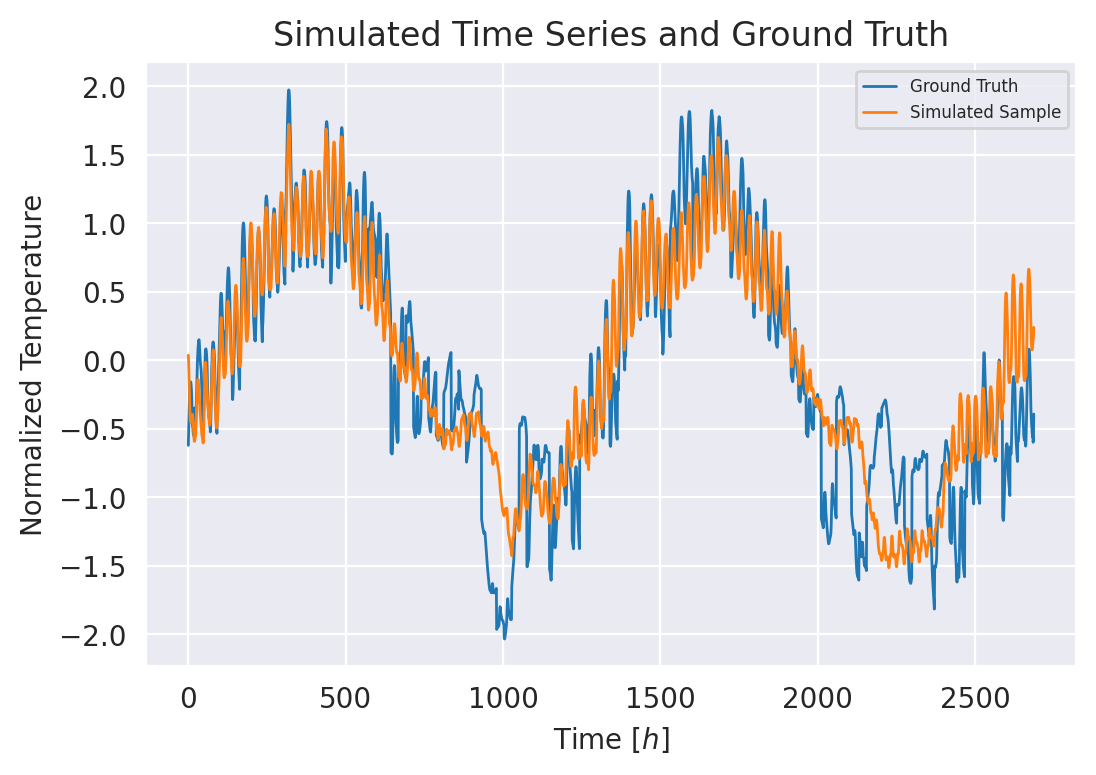

In [42]:
plt.plot(gt[0, :, 0].squeeze(), lw=1, label="Ground Truth")
plt.plot(ts[0, :, 0].squeeze(), lw=1, label="Simulated Sample")
plt.xlabel("Time $[h]$")
plt.ylabel("Normalized Temperature")
plt.title("Simulated Time Series and Ground Truth")
plt.legend()

In [43]:
psc.SMOOTHING_SIGMA = 1
psc.FREQUENCY_CUTOFF = int(1e9)


def better_plot_spectrum_comparison(s_true, s_gen):
    plt.plot(s_true / s_true.sum(), lw=1, label='ground truth')
    plt.plot(s_gen / s_gen.sum(), lw=1, label='generated')
    #  plt.savefig(".pdf")
    plt.legend()
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()


psc.plot_spectrum_comparison = better_plot_spectrum_comparison

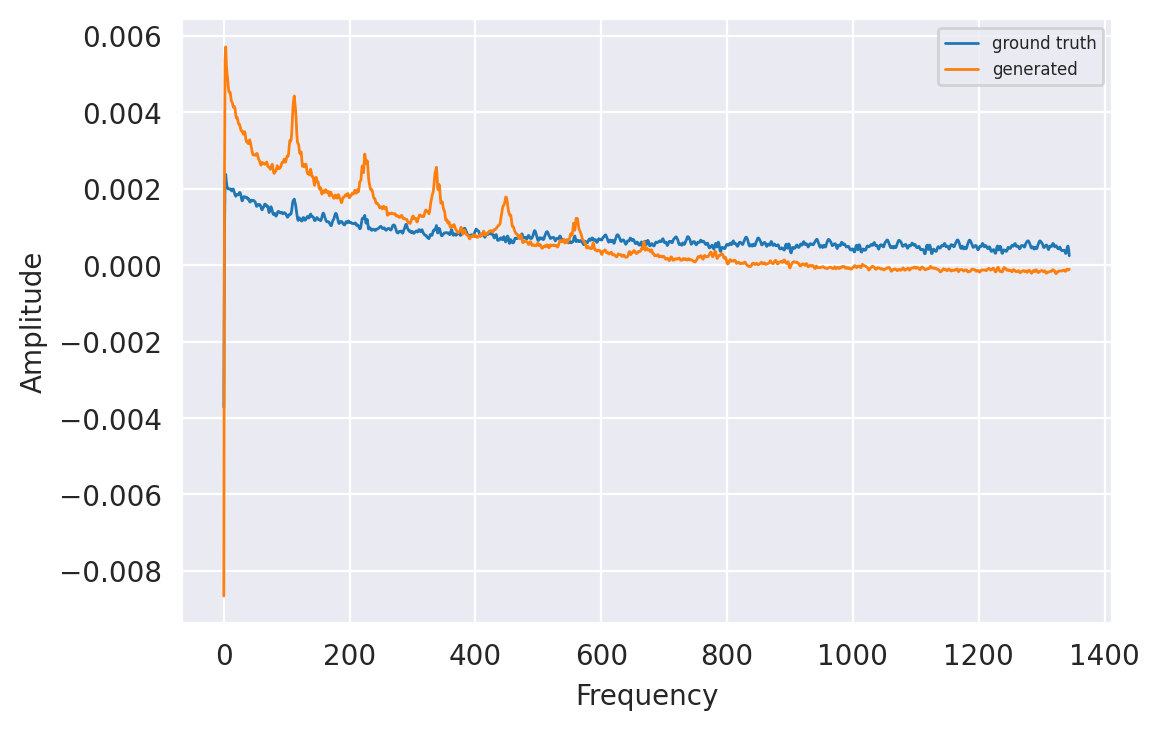

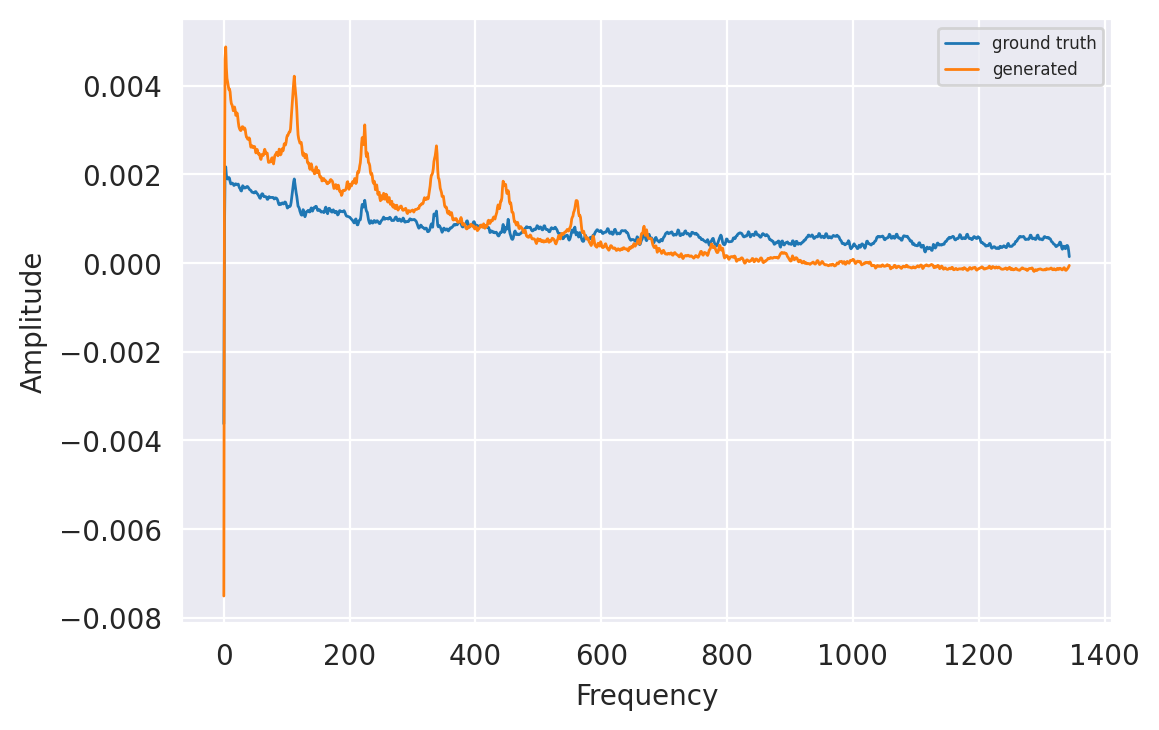

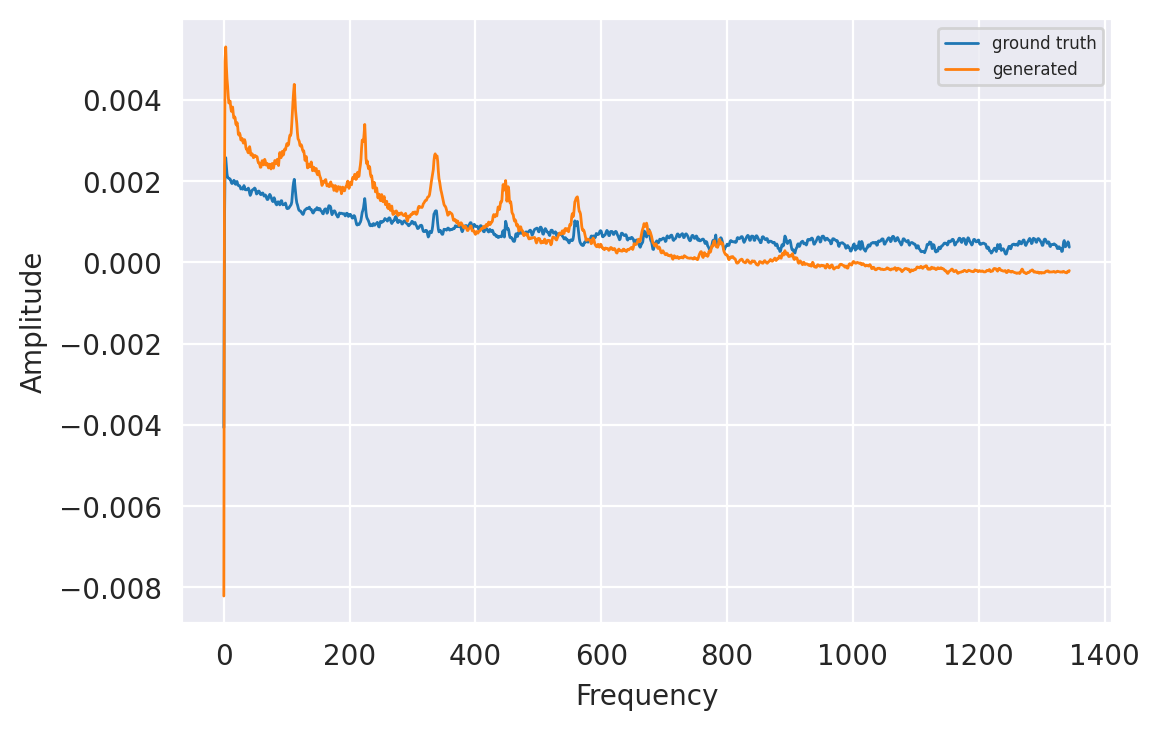

In [44]:
# seems this function is misnamed a bit, since it returns correlation (accuracy) rather than error
corrs = psc.power_spectrum_error_per_dim(gt, ts)

In [45]:
print(f"Correlations are:")
print([f"{c:.4f}" for c in corrs])

Correlations are:
['0.9477', '0.9236', '0.9194']


The correlations are close to 1, suggesting the model properly learns the data periodicities.

## Appendix A: Probabilistic RNN model <a name="appendix"></a>

In task 3, we were given the option to train a PRNN. We also did this, albeit without much success, so here it is in the appendix.

Probabilistic RNN as latent model
$$
z_{t+1}=A\mathrm{ReLU}(z_t)+\epsilon_t,\quad\epsilon_t\sim\mathcal{N}(0,\Sigma),\quad z_0\sim\mathcal{N}(\mu_0,\Sigma)
$$
and a linear observation equation
$$
x_t = Bz_t+\eta_t,\quad\eta_t\sim\mathcal{N}(0,\Gamma)
$$

Using the transformation $y=Az$, we get these equivalent equations from $z_{t+1}=\mathrm{ReLU}(Az_t)+\epsilon_t$. The equations with $A$ inside ReLU would result in integrals for e.g. $\mathbb{E}[z_t\phi(A\cdot z_t)]$, while the integrals for the equations with $A$ outside of the ReLU can be calculated numerically.

This model is trained with the Expectation-Maximization-algorithm.

The E-Step consists of the nonlinear Kalman-Filter-Smoother equation.
$$
\begin{align}
    \mu_t &= f(\mu_{t-1}) + K_t[x_t - g(f(\mu_t))] \\
    V_t &= L_{t-1} - K_t\nabla_{t-1}L_{t-1} \\
    K_t &= L_{t-1} \nabla_{t-1}^T(\nabla_{t-1}L_{t-1}\nabla_{t-1}^T + \Gamma)^{-1} \\
    L_{t-1} &= J_{t-1} V_{t-1}J_{t-1}^T + \Sigma \\
    \nabla_{t-1, ij} &= \frac{\partial g_i}{\partial f}(\mu_{t-1,j}) \\
    J_{t-1} &= \frac{\partial f_i}{\partial z_{t-1}}\mid_{z_{t-1}=\mu_{t-1}}
\end{align}
$$
where $f(z_{t-1}) = A \mathrm{ReLU}(z_{t-1})$, $g(z_t) = B z_t$. Therefore
$$
    \nabla_{t-1} = B, \qquad J_{t-1} = A \cdot \mathrm{diag}(\mathrm{Step}(\mu_{t-1}))
$$

The equations for the M-step are similar to the VAR, only $A$ and $\Sigma$ change:
$$
\begin{align}
    A &= \left(\sum_{t=2}^T\mathbb{E}[z_t \phi(z_{t-1})^T]\right)\cdot\left(\sum_{t=1}^{T-1}\mathbb{E}[\phi(z_t) \phi(z_{t})^T]^T\right)^{-1}, \\
    \Sigma &= \frac{1}{T} \left( \sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T] - A\cdot\sum_{t=2}^T\mathbb{E}[z_t \phi(z_{t-1})^T] \right). \\
\end{align}
$$
Unfortunately, this model does not converge (see below). Therefore we tried to improve it by adding a bias term to the transition equation $z_t = A\mathrm{ReLU}(z_{t-1})+h+\epsilon_t$. Then the M-Step changes to ($\mu_0, B, \Gamma$ stay the same):
$$
\begin{align}
    A &= \left[\sum_{t=2}^T\mathbb{E}[z_t \phi(z_{t-1})^T] - \frac{1}{T-1}\left(\sum_{t=2}^T\mathbb{E}[z_t]\right)\left(\sum_{t=2}^T\mathbb{E}[\phi(z_t)]\right)\right] \cdot \left[\sum_{t=1}^{T-1}\mathbb{E}[\phi(z_t) \phi(z_{t})^T]  - \frac{1}{T-1}\left(\sum_{t=2}^T\mathbb{E}[\phi(z_t)]\right)\left(\sum_{t=2}^T\mathbb{E}[\phi(z_t)]\right)\right]^{-1}, \\
    h &= \frac{1}{T-1}\sum_{t=2}^T\left(\mathbb{E}[z_t] - A \mathbb{E}[\phi(z_t)]\right)\\
    \Sigma &= \frac{1}{T} \left[ \sum_{t=2}^{T}\mathbb{E}[z_t z_{t}^T] - 2A\cdot\sum_{t=2}^T\mathbb{E}[z_t \phi(z_{t-1})^T]^T + A\cdot\sum_{t=1}^{T-1}\mathbb{E}[\phi(z_z) \phi(z_t)^T]^T\cdot A^T -2h\sum_{t=2}^T\mathbb{E}[z_t]^T + 2h\sum_{t=2}^T\mathbb{E}[\phi(z_t)]^TA^T \right] + \frac{T-1}{T}hh^T. \\
\end{align}
$$




The expectations not containing $\phi$ stay the same, while those with $\phi$ are:
$$
\begin{align}
    \mathbb{E}[z_t\phi(z_{t-1})^T]_{ij} &= \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \mathcal{N}(\begin{pmatrix}z_1\\z_2\end{pmatrix} \mid \begin{pmatrix}\mu_1\\\mu_2\end{pmatrix}, \begin{pmatrix}\sigma_1^2&\rho\sigma_1\sigma_2\\\rho\sigma_1\sigma_2&\sigma_2^2\end{pmatrix}) z_1 \mathrm{ReLU}(z_2) \mathrm{d}z_1\mathrm{d}z_2 ,\quad \text{with $z_{1,2}=z_{i,j}, \mu_{1,2},\rho\sigma_{1,2}$ from Kalman-Smoother} \\
    &= \int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2 \left(\int_{-\infty}^{\infty} \mathcal{N}\left(z1; \mu_1+\frac{\rho\sigma_1}{\sigma_2}(z_2-\mu_2), \sigma_1^2(1-\rho^2)\right) z_1\mathrm{d}z_1\right)\mathrm{d}z_2 \\
    &= \int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2 \left(\mu_1+\frac{\rho\sigma_1}{\sigma_2}(z_2-\mu_2)\right) \mathrm{d}z_2 \\
    &= \frac{\rho\sigma_1}{\sigma_2}\int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2^2 \mathrm{d}z_2 + \left(\mu_1-\frac{\rho\sigma_1}{\sigma_2}\mu_2\right)\int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2 \mathrm{d}z_2 \\
    &= \frac{\rho\sigma_1}{\sigma_2} \left[\frac{\mu_2\sigma_2}{\sqrt{2\pi}}e^{-\mu_2^2/(2\sigma_2^2)} + \frac{\mu_2^2+\sigma_2^2}{2}\left(1 + \mathrm{erf}\left(\frac{\mu_2}{\sqrt{2}\sigma_2}\right)\right)\right] + \left(\mu_1-\frac{\rho\sigma_1}{\sigma_2}\mu_2\right) \left[ \frac{\mu_2}{2}\left(1+\mathrm{erf}\left(\frac{\mu_2}{\sqrt{2}\sigma_2}\right)\right) + \frac{\sigma_2}{\sqrt{2\pi}}e^{-\mu_2^2/(2\sigma_2^2}\right] \\
    &= \frac{\mu_2\sigma_2}{\sqrt{2\pi}}\mathrm{exp}\left(-\frac{\mu_2^2}{2\sigma_2^2}\right) + \frac{\rho\sigma_1\sigma_2+\mu_1\mu_2}{2}\left(1+\mathrm{erf}\left(\frac{\mu_2}{\sqrt{2}\sigma_2}\right)\right) \\
    \mathbb{E}[\phi(z_t)]_{i} &= \int_{-\infty}^{\infty}\mathcal{N}(z_i;\mu_i, \sigma_i^2)\mathrm{ReLU}(z_i)\mathrm{d}z_i \\
    &= \frac{\sigma_i}{\sqrt{2\pi}}\mathrm{exp}\left(-\frac{\mu_i^2}{2\sigma_i^2}\right) + \frac{\mu_i}{2}\left(1 + \mathrm{erf}\left(\frac{\mu_i}{\sqrt{2}\sigma_i}\right)\right)\\ \\
    \mathbb{E}[\phi(z_t)\phi(z_t)^T]_{ii} &= \int_{-\infty}^{\infty}\mathcal{N}(z_i;\mu_i, \sigma_i^2)\mathrm{ReLU}(z_i)^2\mathrm{d}z_i \\
    &= \frac{\mu_i\sigma_i}{\sqrt{2\pi}}\mathrm{exp}\left(-\frac{\mu_i^2}{2\sigma_i^2}\right) + \frac{\mu_i^2+\sigma_i^2}{2}\left(1 + \mathrm{erf}\left(\frac{\mu_i}{\sqrt{2}\sigma_i}\right)\right)\\
    \mathbb{E}[\phi(z_t)\phi(z_t)^T]_{ij} &= \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} \mathcal{N}(\begin{pmatrix}z_1\\z_2\end{pmatrix} \mid \begin{pmatrix}\mu_1\\\mu_2\end{pmatrix}, \begin{pmatrix}\sigma_1^2&\rho\sigma_1\sigma_2\\\rho\sigma_1\sigma_2&\sigma_2^2\end{pmatrix}) \cdot \mathrm{ReLU}(z_1) \cdot \mathrm{ReLU}(z_2) \mathrm{d}z_1\mathrm{d}z_2\\
    &= \int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2 \left(\int_{0}^{\infty} \mathcal{N}\left(z1; \underbrace{\mu_1+\frac{\rho\sigma_1}{\sigma_2}(z_2-\mu_2)}_{=\mu}, \underbrace{\sigma_1^2(1-\rho^2)}_{=\sigma}\right) z_1\mathrm{d}z_1\right)\mathrm{d}z_2 \\
    &= \int_{0}^{\infty} \mathcal{N}(z_2;\mu_2,\sigma_2^2)z_2 \left[ \frac{\mu}{2}\left( 1 + \mathrm{erf}\left(\frac{\mu}{\sqrt{2}\sigma}\right)\right) + \frac{\sigma}{\sqrt{2\pi}}\mathrm{exp}\left(-\frac{\mu^2}{2\sigma^2}\right)  \right] \mathrm{d}z_2
\end{align}
$$
The last integral cannot be simplified/rewritten in terms of elementary functions/erf/... Therefore this has to be calculated numerically. We use scipy.quad_vec in order to calculate the integral for every $(i,j)\in\{0,\text{latent_dim}\}^2$ simultaneously.

In [5]:
# Relu and its derivative
def ReLU_diff(x):
    return 1. * (x > 0)


def ReLU(x):
    return np.maximum(x, 0)

In [ ]:
class Probabilistic_RNN:
    """Probabilistic RNN with coupled probabilistic linear observation equation:
        z(t) = A @ ReLU(z(t-1)) + epsilon(t)
        x(t) = B @ z(t) + eta(t)
        z(0) ~ N(mu0, Sigma)
        epsilon(t) ~ N(0, Sigma), eta(t) ~ N(0, Gamma)
    """

    def __init__(self, A, Sigma, mu0, B, Gamma, h=None):
        """Initialize the model with initial parameters"""
        self.set_parameters(A, Sigma, mu0, B, Gamma, h=h)
        self.latent_dim = Sigma.shape[0]
        self.obs_dim = Gamma.shape[0]

    def set_parameters(self, A, Sigma, mu0, B, Gamma, h=None):
        """Set new model parameters"""
        self.A = A
        self.Sigma = Sigma
        self.mu0 = mu0
        self.B = B
        self.Gamma = Gamma
        self.h = h

    def get_parameters(self):
        """Returns dict with model parameters"""
        return {
            "A": self.A,
            "Sigma": self.Sigma,
            "mu0": self.mu0,
            "B": self.B,
            "Gamma": self.Gamma,
            "h": self.h
        }

    def generate_time_series(self, T):
        """Generates a time series starting from mu0

        Args:
            T: length of time series

        Returns:
            The tuple (z, x) containing the latent space time
            series z of shape (T, latent_dim) and the
            observed time series x of shape (T, obs_dim)
        """
        z = np.zeros(shape=(T, self.latent_dim))
        x = np.zeros(shape=(T, self.obs_dim))

        # Noise for the latent space transition equation
        epsilon = np.random.multivariate_normal(np.zeros(self.latent_dim), self.Sigma, size=T)
        # Noise for the observation equation
        eta = np.random.multivariate_normal(np.zeros(self.obs_dim), self.Gamma, size=T)

        # sample z0 using the estimated mu0
        z[0] = np.random.multivariate_normal(self.mu0, self.Sigma)
        x[0] = self.B @ z[0] + eta[0]

        # iterate over the remaining time steps either with or without h,
        # depending on whether it was given in __init__
        if self.h is None:
            for t in range(1, T):
                z[t] = self.A @ ReLU(z[t - 1]) + epsilon[t]
                x[t] = self.B @ z[t] + eta[t]
        else:
            for t in range(1, T):
                z[t] = self.A @ ReLU(z[t - 1]) + self.h + epsilon[t]
                x[t] = self.B @ z[t] + eta[t]

        return z, x

    def estimate_parameters(self, x, E_z, E_zz, E_phiz, E_zphiz1, E_phizphiz):
        """Performs the M-Step of the Expectation-Maximization algorithm using the equations above and from the VAR

        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_phiz = (E[phi(z_t)])_t: of shape (T, latent_dim)
                E_zphiz1 = (E[z_t @ phi(z_{t-1})^T])_t: of shape (T-1, latent_idm, latent_dim)
                E_phizphiz = (E[phi(z_t) @ phi(z_t)^T])_t: of shape (T, latent_idm, latent_dim)

        Returns:
            Tuple with new estimates of the model parameters in the same order as in __init__, i.e.
            (A, Sigma, mu0, B, Gamma), or (A, Sigma, mu0, B, Gamma, h) if h was defined in __init__
        """
        T = len(x)

        if self.h is None:

            # solve instead of inv for better precision
            A_new = np.linalg.solve(np.sum(E_phizphiz[:-1], axis=0).T, np.sum(E_zphiz1, axis=0).T).T

            Sigma_new = 1 / T * (
                        np.sum(E_zz[1:], axis=0) - np.sum(E_zphiz1, axis=0) @ A_new.T - A_new @ np.sum(E_zphiz1,
                                                                                                       axis=0) + A_new @ np.sum(
                    E_phizphiz[:-1], axis=0) @ A_new.T)
            # restrict Sigma to be > 1e-7 and make it diagonal. Otherwise it wouldn't necessarily be positive semi-definite
            Sigma_new = np.maximum(Sigma_new, 1e-7)
            Sigma_new = np.diag(np.diag(Sigma_new))

        else:

            E_phiz_sum = np.sum(E_phiz[:-1], axis=0)
            E_z_sum = np.sum(E_phiz[1:], axis=0)

            A_new = np.linalg.solve(
                (np.sum(E_phizphiz[:-1], axis=0) - 1 / (T - 1) * E_phiz_sum @ E_phiz_sum.T).T,
                (np.sum(E_zphiz1, axis=0) - 1 / (T - 1) * E_z_sum @ E_phiz_sum.T).T
            ).T

            h_new = 1 / (T - 1) * (E_z_sum - A_new @ E_phiz_sum)

            Sigma_new = 1 / T * (np.sum(E_zz[1:], axis=0) - 2 * A_new @ np.sum(E_zphiz1, axis=0).T + A_new @ np.sum(
                E_phizphiz[:-1], axis=0) @ A_new.T - 2 * h_new @ E_z_sum.T + 2 * h_new @ (A_new @ E_phiz_sum).T) + (
                                    T - 1) / T * h_new @ h_new.T
            # restrict Sigma to be > 1e-7 and make it diagonal. Otherwise it wouldn't necessarily be positive semi-definite
            Sigma_new = np.maximum(Sigma_new, 1e-7)
            Sigma_new = np.diag(np.diag(Sigma_new))

        mu0_new = E_z[0]

        sum_t_x_Ez = np.einsum("ij,il->jl", x, E_z)

        #B_new = sum_t_x_Ez @ np.linalg.inv(np.sum(E_zz, axis=0))
        B_new = np.linalg.solve(np.sum(E_zz, axis=0).T, sum_t_x_Ez.T).T

        sum_t_x_Ez_BT = sum_t_x_Ez @ B_new.T
        Gamma_new = 1 / T * (np.einsum("ij,il->jl", x, x) - sum_t_x_Ez_BT - sum_t_x_Ez_BT.T + B_new @ np.sum(E_zz,
                                                                                                             axis=0) @ B_new.T)
        # restrict Gamma to be > 1e-7 and make it diagonal. Otherwise it wouldn't necessarily be positive semi-definite
        Gamma_new = np.maximum(Gamma_new, 1e-7)
        Gamma_new = np.diag(np.diag(Gamma_new))

        # Use a "learning rate" such that it doesn't diverge that fast
        lr = 1e-1
        if self.h is None:
            return (1 - lr) * self.A + lr * A_new, (1 - lr) * self.Sigma + lr * Sigma_new, (
                        1 - lr) * self.mu0 + lr * mu0_new, (1 - lr) * self.B + lr * B_new, (
                               1 - lr) * self.Gamma + lr * Gamma_new
        else:
            return (1 - lr) * self.A + lr * A_new, (1 - lr) * self.Sigma + lr * Sigma_new, (
                        1 - lr) * self.mu0 + lr * mu0_new, (1 - lr) * self.B + lr * B_new, (
                               1 - lr) * self.Gamma + lr * Gamma_new, (1 - lr) * self.h + lr * h_new

    def expected_log_likelihood(self, x, E_z, E_zz, E_phiz, E_zphiz1, E_phizphiz):
        """Calculates the expected log-likelihood of this model

        Args:
            x: observed time series of shape (T, obs_dim)
            Expectations containing the latent variable z:
                E_z = (E[z_t])_t: of shape (T, latent_dim)
                E_zz = (E[z_t @ z_t^T])_t: of shape(T, latent_dim, latent_dim)
                E_phiz = (E[phi(z_t)])_t: of shape (T, latent_dim)
                E_zphiz1 = (E[z_t @ phi(z_{t-1})^T])_t: of shape (T-1, latent_idm, latent_dim)
                E_phizphiz = (E[phi(z_t) @ phi(z_t)^T])_t: of shape (T, latent_idm, latent_dim)

        Returns:
            The expected log-likelihood
        """
        Sigma_inv = np.linalg.inv(self.Sigma)
        Gamma_inv = np.linalg.inv(self.Gamma)
        T = len(x)

        ell = T * np.linalg.slogdet(self.Sigma)[1] + T * np.linalg.slogdet(self.Gamma)[1]
        ell += np.trace(Sigma_inv @ E_zz[1:], axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.A.T @ Sigma_inv @ E_zphiz1, axis1=1, axis2=2).sum()
        ell += np.trace(self.A.T @ Sigma_inv @ self.A @ E_phizphiz[:-1], axis1=1, axis2=2).sum()
        if self.h is not None:
            ell += -2 * self.h.T @ Sigma_inv @ np.sum(E_z[1:], axis=0)
            ell += 2 * self.h.T @ Sigma_inv @ self.A @ np.sum(E_phiz[:-1], axis=0)
            ell += self.h.T @ Sigma_inv @ self.h

        ell += np.trace(Gamma_inv @ np.einsum("ij,il->ijl", x, x), axis1=1, axis2=2).sum()
        ell += -2 * np.trace(self.B.T @ Gamma_inv @ np.einsum("ij,il->ijl", x, E_z), axis1=1, axis2=2).sum()
        ell += np.trace(self.B.T @ Gamma_inv @ self.B @ E_zz, axis1=1, axis2=2).sum()

        return -ell / 2.

In [ ]:
def Extended_Kalman_Filter_Smoother(x, A, Sigma, mu0, B, Gamma, L0, h=None):
    """Performs the Extended Kalman-Filter-Smoother algorithm for nonlinear latent space models
    """
    if h is None:
        def f(z_ts1):
            return A @ ReLU(z_ts1)
    else:
        def f(z_ts1):
            return A @ ReLU(z_ts1) + h

    def f_diff(x):
        return A @ np.diag(ReLU_diff(x))

    def g(z_t):
        return B @ z_t

    def nabla():
        return B

    # Initialize all variables
    p = Sigma.shape[0]
    q = Gamma.shape[0]
    T = len(x)
    K = np.zeros(shape=(T, p, q))
    L = np.zeros(shape=(T, p, p))
    mu = np.zeros(shape=(T, len(mu0)))
    V = np.zeros(shape=(T, p, p))
    J = np.zeros(shape=(T, p, p))
    mu_tilde = np.zeros(shape=mu.shape)
    V_tilde = np.zeros(shape=V.shape)
    V_tt1 = np.zeros(shape=V.shape)  # = cov_theta[z_t,z_{t-1} | {x_t}_{t=1...T}]

    # Kalman Filter

    # First step using initial conditions
    # Use solve instead of inv for higher precision
    K[0] = np.linalg.solve((nabla() @ L0 @ nabla().T + Gamma).T, (L0 @ nabla().T).T).T
    V[0] = (np.eye(p) - K[0] @ nabla()) @ L0
    #V[0] = (np.eye(p) - K[0] @ B) @ L0 @ (np.eye(p) - K[0] @ B).T + K[0] @ Gamma @ K[0].T
    L[0] = L0
    mu[0] = f(mu0) + K[0] @ (x[0] - g(f(mu0)))
    J[0] = np.eye(p)

    # loop over the remaining time steps
    for t in range(1, T):
        J[t] = f_diff(mu[t - 1])
        L[t] = J[t] @ V[t - 1] @ J[t].T + Sigma
        #K[t] = L[t] @ B.T @ np.linalg.inv((B @ L[t] @ B.T + Gamma))
        K[t] = np.linalg.solve((nabla() @ L[t] @ nabla().T + Gamma).T, (L[t] @ nabla().T).T).T
        mu[t] = f(mu[t - 1]) + K[t] @ (x[t] - g(f(mu[t - 1])))
        V[t] = (np.eye(p) - K[t] @ nabla()) @ L[t]
        #V[t] = (np.eye(p) - K[t] @ B) @ L[t] @ (np.eye(p) - K[t] @ B).T + K[t] @ Gamma @ K[t].T

    # Kalman Smoother

    # first value in the smoother step equals the last value of the filter step
    mu_tilde[-1] = mu[-1]
    V_tilde[-1] = V[-1]

    for t in range(T - 2, -1, -1):
        Z = np.linalg.solve(L[t + 1].T, (V[t] @ J[t + 1].T).T).T
        V_tilde[t] = V[t] + Z @ (V_tilde[t + 1] - L[t + 1]) @ Z.T
        mu_tilde[t] = mu[t] + Z @ (mu_tilde[t + 1] - J[t + 1] @ mu[t])
        V_tt1[t + 1] = V_tilde[t + 1] @ Z.T

    return mu, V, mu_tilde, V_tilde, V_tt1

In [ ]:
try:
    # Since Multiprocessing does not work with Jupyter lab when the function is defined inside the .ipynb file,
    # we created a .py file called "integrate_E_phizphiz". This file contains exactly the same code as in the except-block
    # The except-block contains the fallback-solution without parallelization if "integrate_E_phizphiz.py" does not exist,
    # but the integration in E[phi(z_t) @ phi(z_t)] is very slow
    from integrate_E_phizphiz import integrate_phizphiz

    parallel = True

except ImportError:
    import numpy as np
    from scipy.integrate import quad_vec
    from scipy.special import erf


    def integrate_phizphiz(params):
        t, mu, V = params

        res = np.zeros(shape=(V.shape[1], V.shape[2]))

        # integrates all integrals for i, j simultaneously

        mu1_vec = []
        mu2_vec = []
        s1_vec = []
        s2_vec = []
        rho_vec = []

        # collect all necessary parameters in arrays
        for i in range(V.shape[1]):
            for j in range(i + 1, V.shape[2]):
                mu1_vec.append(mu[t, i])
                mu2_vec.append(mu[t, j])
                s1_vec.append(np.sqrt(V[t, i, i]))
                s2_vec.append(np.sqrt(V[t, j, j]))
                rho_vec.append(V[t, i, j] / (s1_vec[-1] * s2_vec[-1]))

        mu1_vec = np.array(mu1_vec)
        mu2_vec = np.array(mu2_vec)
        s1_vec = np.array(s1_vec)
        s2_vec = np.array(s2_vec)
        rho_vec = np.array(rho_vec)

        mu_vec = lambda z2: mu1_vec + rho_vec * s1_vec / s2_vec * (z2 - mu2_vec)
        s_vec = np.sqrt(s1_vec ** 2 * (1 - rho_vec ** 2))

        integrand = lambda z2: 1 / np.sqrt(2 * np.pi * s2_vec ** 2) * np.exp(
            -(z2 - mu2_vec) ** 2 / (2 * s2_vec ** 2)) * z2 * (
                                           mu_vec(z2) * (erf(mu_vec(z2) / (np.sqrt(2) * s_vec)) + 1) + np.sqrt(
                                       2 / np.pi) * s_vec * np.exp(-mu_vec(z2) ** 2 / (2 * s_vec ** 2))) / 2

        # all integrals simultaneously
        res_vec = quad_vec(integrand, 0, np.Inf)[0]

        # create strictly upper triangular matrix from results of the integrals
        triu_ind = np.triu_indices(V.shape[1], 1)
        res[triu_ind] = res_vec
        # fill strictly lower triangular part
        res += res.T

        # calculate the diagonal
        s_diag_vec = np.sqrt(np.diag(V[t]))
        mu_diag_vec = mu[t]
        res += np.diag((s_diag_vec ** 2 + mu_diag_vec ** 2) / 2 * (
                    erf(mu_diag_vec / (np.sqrt(2) * s_diag_vec)) + 1) + mu_diag_vec * s_diag_vec / np.sqrt(
            2 * np.pi) * np.exp(-mu_diag_vec ** 2 / (2 * s_diag_vec ** 2)))

        return res


    parallel = False


In [ ]:
def calculate_E_phizphiz(mu, V):
    """Calculates the expectation E[phi(z_t) @ phi(z_t)^T]"""
    T = V.shape[0]
    E_phizphiz = np.zeros(shape=V.shape)

    if parallel:
        pool = mp.Pool()
        chunksize = 100
        #for ind, res in enumerate(pool.imap(integrate_phizphiz, tqdm(zip(range(T), itertools.repeat(mu), itertools.repeat(V)), total=T, desc="E_phizphiz", leave=False), chunksize)):
        for ind, res in enumerate(
                pool.imap(integrate_phizphiz, zip(range(T), itertools.repeat(mu), itertools.repeat(V)), chunksize)):
            E_phizphiz[ind] = res

    else:
        #for t in tqdm(range(T), desc="E_phizphiz", leave=False):
        for t in range(T):
            E_phizphiz[t] = integrate_phizphiz((t, mu, V))

    E_phizphiz[np.isnan(E_phizphiz)] = 0

    return E_phizphiz


def calculate_E_zphiz1(mu, V, V_tt1):
    """Calculates the expectation E[z_t @ phi(z_{t-1})^T]"""
    T = V.shape[0]
    latent_dim = V.shape[1]

    # Vectorized version of
    # for t in range(T):
    #     for i in range(latent_dim):
    #         for j in range(latent_dim):
    #             E_zphiz1[t, i, j] = *Solution of Integral as given above*

    mu1_vec = np.repeat(mu[1:], latent_dim).flatten()
    mu2_vec = np.tile(mu[1:], latent_dim).flatten()
    s1_vec = np.repeat(np.sqrt(np.diagonal(V[1:], axis1=1, axis2=2)), latent_dim).flatten()
    s2_vec = np.tile(np.sqrt(np.diagonal(V[:-1], axis1=1, axis2=2)), latent_dim).flatten()
    rho_vec = V_tt1[1:].flatten() / (s1_vec * s2_vec)

    E_zphiz1 = (mu1_vec * mu2_vec + rho_vec * s1_vec * s2_vec) / 2 * (
                erf(mu2_vec / (np.sqrt(2) * s2_vec)) + 1) + mu1_vec * s2_vec / np.sqrt(2 * np.pi) * np.exp(
        -mu2_vec ** 2 / (2 * s2_vec ** 2))
    E_zphiz1 = np.concatenate(
        (np.zeros(shape=(1, latent_dim, latent_dim)), E_zphiz1.reshape((T - 1, latent_dim, latent_dim))), axis=0)

    E_zphiz1[np.isnan(E_zphiz1)] = 0

    return E_zphiz1


def calculate_E_phiz(mu, V):
    """Calculates the expectation Ephi(z_t)]"""
    T = V.shape[0]

    # Vectorized version of
    # for t in range(T):
    #     for i in range(latent_dim):
    #         E_phiz[t, i, j] = *Solution of Integral as given above*

    mu_vec = mu.flatten()
    s_diag_vec = np.sqrt(np.diagonal(V, axis1=1, axis2=2)).flatten()
    E_phiz = mu_vec / 2 * (erf(mu_vec / (np.sqrt(2) * s_diag_vec)) + 1) + s_diag_vec / np.sqrt(2 * np.pi) * np.exp(
        -mu_vec ** 2 / (2 * s_diag_vec ** 2))
    E_phiz = E_phiz.reshape(mu.shape)
    E_phiz[np.isnan(E_phiz)] = 0

    return E_phiz

In [ ]:
def Expectation_Maximization(rnn, x, expected_log_likelihoods, parameter_differences, parameters, MSE_train, MSE_test,
                             max_iter=100, tol=1e-4, path=None):
    """Performs the Expectation-Maximization algorithm

    Args:
        rnn: the probabilistic RNN with linear observation equation
        x: observed time series of shape (T, obs_dim)
        expected_log_likelihoods: List to which the calculated expected log likelihood is appended each iteration
        parameter_differences: This function calculates the maximal absolute parameter difference compared to the previous iteration
        parameters: List of the parameters of each iteration combined into a dict as returned by var.get_parameters()
        MSE_train, MSE_test: Every 10th iteration 10 time series are sampled and calculated with the current model state
            and the averaged mean squared errors for the train and the test set are appended
        max_iter: maximum number of iterations
        path: If None: Save the lists above-mentioned lists to the given folder

    Returns:
        the new model
    """
    parameters.append(rnn.get_parameters())
    ell_prev = 0
    pbar = tqdm(range(max_iter))
    pbar.set_description(f"latent_dim = {rnn.latent_dim}, iteration {0}")
    train_error = 0
    test_error = 0
    for i in pbar:
        old_params = rnn.get_parameters()
        # Perform Kalman-Filter-Smoother algorithm using the current parameters
        mu, V, mu_tilde, V_tilde, V_tt1 = Extended_Kalman_Filter_Smoother(x=x, L0=rnn.Sigma, **old_params)

        # Calculate expectations using the results from the Kalman-Smoother
        E_z = mu_tilde
        E_zz = V_tilde + np.einsum("ij,il->ijl", E_z, E_z)
        E_phiz = calculate_E_phiz(mu_tilde, V_tilde)
        E_phizphiz = calculate_E_phizphiz(mu_tilde, V_tilde)
        E_zphiz1 = calculate_E_zphiz1(mu_tilde, V_tilde, V_tt1)

        # Calculate the new parameters using the expectations and the observed time series
        new_params = rnn.estimate_parameters(x, E_z, E_zz, E_phiz, E_zphiz1, E_phizphiz)
        rnn.set_parameters(*new_params)

        # Calculate the new expected-log-likelihood
        ell = rnn.expected_log_likelihood(x, E_z, E_zz, E_phiz, E_zphiz1, E_phizphiz)

        # Calculate the maximum absolute parameter difference
        max_parameter_difference = max(
            [np.max(np.abs(new_p - old_p)) for (new_p, old_p) in zip(new_params, old_params.values())])

        # Generate 10 time series and calculate the averaged MSE-error for the
        # training set and the test set. Since the predictions depend heavily on the sampled z0,
        # we calculate 10 time series and average over those.
        generated_time_series = np.array([rnn.generate_time_series(len(npa))[1] for _ in range(10)])
        generated_time_series_train = generated_time_series[:, :len(raw_train_data), :]
        generated_time_series_test = generated_time_series[:, len(raw_train_data):, :]
        train_error = ((generated_time_series_train - raw_train_data[np.newaxis, :, :]) ** 2).mean()
        test_error = ((generated_time_series_test - raw_test_data[np.newaxis, :, :]) ** 2).mean()

        if (train_error > 1000 and len(MSE_train) > 0 and train_error > MSE_train[-1]) or (
                i > 50 and ell < expected_log_likelihoods[-1]):
            return rnn

        MSE_train.append(train_error)
        MSE_test.append(test_error)

        pbar.set_description(
            f"latent_dim = {rnn.latent_dim}, iteration {i + 1}, ell = {ell:.{int(-np.log10(tol))}f}, max param difference = {max_parameter_difference:.{int(-np.log10(tol))}f}, MSE_train = {train_error:.4f}, MSE_test = {test_error:.4f}")

        # append new parameters, expected-log-likelihood and parameter differences to the given lists
        parameters.append(rnn.get_parameters())
        expected_log_likelihoods.append(ell)
        parameter_differences.append(max_parameter_difference)

        ell_prev = ell

        # Save the parameters and lists
        if path is not None:
            np.save(path + "A_params.npy", np.array([p["A"] for p in parameters]))
            np.save(path + "Sigma_params.npy", np.array([p["Sigma"] for p in parameters]))
            np.save(path + "mu0_params.npy", np.array([p["mu0"] for p in parameters]))
            np.save(path + "B_params.npy", np.array([p["B"] for p in parameters]))
            np.save(path + "Gamma_params.npy", np.array([p["Gamma"] for p in parameters]))
            np.save(path + "expected_log_likelihoods.npy", expected_log_likelihoods)
            np.save(path + "parameter_differences.npy", parameter_differences)
            np.save(path + "MSE_train.npy", MSE_train)
            np.save(path + "MSE_test.npy", MSE_test)
            if rnn.h is not None:
                np.save(path + "h_params.npy", np.array([p["h"] for p in parameters]))

    return rnn

In [ ]:
def train(latent_dim, max_iter=100, include_bias=False):
    if include_bias:
        path = f"./rnn_params/latent_dim_{latent_dim:03d}_bias_True/"
    else:
        path = f"./rnn_params/latent_dim_{latent_dim:03d}_bias_False/"

    # create (new) folder for the parameters and lists
    pl.Path(path).mkdir(parents=True, exist_ok=True)
    T, obs_dim = raw_train_data.shape
    # Initialize parameters.
    # All parameters are chosen small in order to avoid overflows during the first iterations
    # A_initial is chosen as identity + noise, Sigma and Gamma are diagonal with small positive values
    A_initial = np.eye(latent_dim) * 1e-3 + np.random.uniform(-1e-4, 1e-4, size=(latent_dim, latent_dim))
    Sigma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=latent_dim))
    mu0_initial = np.random.uniform(-1e-4, 1e-4, size=latent_dim)
    B_initial = np.random.uniform(-1e-4, 1e-4, size=(obs_dim, latent_dim))
    Gamma_initial = np.diag(np.random.uniform(1e-6, 1e-2, size=obs_dim))

    if include_bias:
        h_initial = np.random.uniform(-1e-4, 1e-4, size=latent_dim)
        rnn = Probabilistic_RNN(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial, h_initial)
    else:
        rnn = Probabilistic_RNN(A_initial, Sigma_initial, mu0_initial, B_initial, Gamma_initial)

    expected_log_likelihoods = []
    parameter_differences = []
    parameters = []
    MSE_train = []
    MSE_test = []
    rnn = Expectation_Maximization(rnn, raw_train_data, expected_log_likelihoods, parameter_differences, parameters,
                                   MSE_train, MSE_test, max_iter=max_iter, path=path)

    # convert list of dicts to 5 lists of parameters
    A_params = np.array([p["A"] for p in parameters])
    Sigma_params = np.array([p["Sigma"] for p in parameters])
    mu0_params = np.array([p["mu0"] for p in parameters])
    B_params = np.array([p["B"] for p in parameters])
    Gamma_params = np.array([p["Gamma"] for p in parameters])
    if include_bias:
        h_params = np.array([p["h"] for p in parameters])
        np.save(path + "h_params.npy", h_params)

    np.save(path + "A_params.npy", A_params)
    np.save(path + "Sigma_params.npy", Sigma_params)
    np.save(path + "mu0_params.npy", mu0_params)
    np.save(path + "B_params.npy", B_params)
    np.save(path + "Gamma_params.npy", Gamma_params)
    np.save(path + "expected_log_likelihoods.npy", expected_log_likelihoods)
    np.save(path + "parameter_differences.npy", parameter_differences)
    np.save(path + "MSE_train.npy", MSE_train)
    np.save(path + "MSE_test.npy", MSE_test)

In [ ]:
for bias in [False, True]:
    for latent_dim in [4, 8, 16, 32, 64]:
        train(latent_dim, max_iter=250, include_bias=bias)

In [ ]:
for bias in ["False", "True"]:
    for latent_dim in [4, 8, 16, 32, 64]:
        expected_log_likelihoods = np.load(
            f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/expected_log_likelihoods.npy")
        parameter_differences = np.load(
            f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/parameter_differences.npy")
        MSE_train = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/MSE_train.npy")
        MSE_test = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/MSE_test.npy")
        index = np.argmin(MSE_train[3:])
        A = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/A_params.npy")[index]
        Sigma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Sigma_params.npy")[index]
        mu0 = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/mu0_params.npy")[index]
        B = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/B_params.npy")[index]
        Gamma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Gamma_params.npy")[index]
        if bias == "True":
            h = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/h_params.npy")[index]
            rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma, h)
        else:
            rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma)

        # Plot the expected-log-likelihood and the parameter differences on the left side
        # and the MSE_train and MSE_test on the right side
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        ax1 = axes[0]
        ax2 = ax1.twinx()
        start = 5
        ax1.plot(np.arange(start, len(expected_log_likelihoods)), expected_log_likelihoods[start:], 'C0',
                 label="Expected Log Likelihood")
        ax2.plot(np.arange(start, len(expected_log_likelihoods)), parameter_differences[start:], 'C1',
                 label="Max Parameter Difference")
        ax1.set_xlabel("epoch")
        ax1.set_ylabel(r"$\mathbb{E}_q[\log p(Z,X)]$")
        ax2.set_ylabel("Max Parameter Difference")
        ax1.set_yscale("log")
        ax2.set_yscale("log")
        ax1.set_title("Expected log likelihood and max parameter difference")
        ax1.legend(loc=2)
        ax2.legend(loc=1)

        axes[1].plot(MSE_train, label="MSE train loss")
        axes[1].plot(MSE_test, label="MSE test loss")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("MSE loss")
        axes[1].set_title("MSE train/test loss averaged over 10 time series")
        axes[1].legend()

        # Calculate 1000 time series using the best PRNN, calculate the MSE-error for the training set and test set
        # and add them to the title
        generated_time_series = np.array([rnn.generate_time_series(len(npa))[1] for _ in range(1000)])
        generated_time_series_train = generated_time_series[:, :len(raw_train_data), :]
        generated_time_series_test = generated_time_series[:, len(raw_train_data):, :]
        train_error = ", ".join([str(n) for n in np.round(
            ((generated_time_series_train - raw_train_data[np.newaxis, :, :]) ** 2).mean(axis=1).mean(axis=0), 1)])
        test_error = ", ".join([str(n) for n in np.round(
            ((generated_time_series_test - raw_test_data[np.newaxis, :, :]) ** 2).mean(axis=1).mean(axis=0), 1)])

        plt.suptitle(
            f"latent_dim = {latent_dim}, bias = {bias}, VAR at max ell: MSE_train = [{train_error}], MSE_test = [{test_error}]")

        plt.tight_layout()
        plt.show()


We initialize the PRNN's weights small enough, that predicts "0 + noise". Otherwise it quickly results in overflows. During the first few iterations, the MSE-train-loss decreases but it eventually increases and even diverges. This can be seen in especially in the plots with the bias term, but occurs for all hyperparameters. The reason that it is not visible in all plot is that the EM-algorithm returns early when the MSE-loss starts to diverge. If we continued training, the MSE-loss would increase further and would not return to sensible predictions.

Although the MSE-loss decreases and is lower than the VAR, the PRNN still only predicts approximately "0 + noise". But in both following plots, one can see, that the predictions sometimes deviates from 0. Therefore it could be possible, that the PRNN learns the dynamics with different hyperparameters (i.e. latent_dim, bias and the learning rate in parameter estimation).

In [ ]:
for (latent_dim, bias) in [(8, "False"), (4, "True")]:
    MSE_train = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/MSE_train.npy")
    index = np.argmin(MSE_train[3:])
    A = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/A_params.npy")[index]
    Sigma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Sigma_params.npy")[index]
    mu0 = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/mu0_params.npy")[index]
    B = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/B_params.npy")[index]
    Gamma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Gamma_params.npy")[index]
    if bias == "True":
        h = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/h_params.npy")[index]
        rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma, h)
    else:
        rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma)

    ts = rnn.generate_time_series(len(npa))[1]

    fig, axes = plt.subplots(3, 1, figsize=(10, 6))
    t_train = np.arange(len(raw_train_data))
    t_test = np.arange(len(raw_train_data), len(raw_train_data) + len(raw_test_data))
    for i in range(3):
        axes[i].plot(t_train, raw_train_data[:, i], c="C0", label="train set")
        axes[i].plot(t_test, raw_test_data[:, i], c="C1", label="test set")
        axes[i].plot(ts[:, i], c=f"C2", lw=.5, label="generated")
        axes[i].legend()
    plt.suptitle(
        f"Observed time series with a generated time series\nfrom the best PRNN with latent_dim = {latent_dim}, bias = {bias}")
    plt.tight_layout()
    plt.show()


The predictions when it starts to diverge:

In [ ]:
latent_dim = 64
bias = "True"
index = -3
A = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/A_params.npy")[index]
Sigma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Sigma_params.npy")[index]
mu0 = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/mu0_params.npy")[index]
B = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/B_params.npy")[index]
Gamma = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/Gamma_params.npy")[index]
if bias == "True":
    h = np.load(f"./rnn_params/latent_dim_{latent_dim:03d}_bias_{bias}/h_params.npy")[index]
    rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma, h)
else:
    rnn = Probabilistic_RNN(A, Sigma, mu0, B, Gamma)

ts = rnn.generate_time_series(len(npa))[1]

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
t_train = np.arange(len(raw_train_data))
t_test = np.arange(len(raw_train_data), len(raw_train_data) + len(raw_test_data))
for i in range(3):
    axes[i].plot(t_train, raw_train_data[:, i], c="C0", label="train set")
    axes[i].plot(t_test, raw_test_data[:, i], c="C1", label="test set")
    axes[i].plot(ts[:, i], c=f"C2", lw=.5, label="generated")
    axes[i].legend()
plt.suptitle(
    f"Observed time series with a generated time series from the best PRNN with latent_dim = {latent_dim}, bias = {bias}")
plt.tight_layout()
plt.show()
